In [1]:
import os
import logging
import dill as pickle
import urllib
import random
from tqdm import tqdm
import sys
import codecs
import spacy
import time

import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tarfile
import torchtext.data
import torchtext.datasets

import argparse

In [2]:
device = torch.device("cuda", index=0)
output_dir = './output_lambda=0.5'
lambda_ = 0.5

In [3]:
_TRAIN_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/" \
             "training-parallel-nc-v12.tgz",
     "trg": "news-commentary-v12.de-en.en",
     "src": "news-commentary-v12.de-en.de"}
    ]

_VAL_DATA_SOURCES = [
    {"url": "http://data.statmt.org/wmt17/translation-task/dev.tgz",
     "trg": "newstest2013.en",
     "src": "newstest2013.de"}]

_TEST_DATA_SOURCES = [
    {"url": "https://storage.googleapis.com/tf-perf-public/" \
                "official_transformer/test_data/newstest2014.tgz",
     "trg": "newstest2014.en",
     "src": "newstest2014.de"}]

In [4]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def file_exist(dir_name, file_name):
    for sub_dir, _, files in os.walk(dir_name):
        if file_name in files:
            return os.path.join(sub_dir, file_name)
    return None

In [5]:
def download_and_extract(download_dir, url, src_filename, trg_filename):
    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        sys.stderr.write(f"Already downloaded and extracted {url}.\n")
        return src_path, trg_path

    compressed_file = _download_file(download_dir, url)

    sys.stderr.write(f"Extracting {compressed_file}.\n")
    with tarfile.open(compressed_file, "r:gz") as corpus_tar:
        corpus_tar.extractall(download_dir)

    src_path = file_exist(download_dir, src_filename)
    trg_path = file_exist(download_dir, trg_filename)

    if src_path and trg_path:
        return src_path, trg_path

    raise OSError(f"Download/extraction failed for url {url} to path {download_dir}")

def _download_file(download_dir, url):
    filename = url.split("/")[-1]
    if file_exist(download_dir, filename):
        sys.stderr.write(f"Already downloaded: {url} (at {filename}).\n")
    else:
        sys.stderr.write(f"Downloading from {url} to {filename}.\n")
        with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=filename) as t:
            urllib.request.urlretrieve(url, filename=filename, reporthook=t.update_to)
    return filename

def get_raw_files(raw_dir, sources):
    raw_files = { "src": [], "trg": [], }
    for d in sources:
        src_file, trg_file = download_and_extract(raw_dir, d["url"], d["src"], d["trg"])
        raw_files["src"].append(src_file)
        raw_files["trg"].append(trg_file)
    return raw_files

In [6]:
def mkdir_if_needed(dir_name):
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)

In [7]:
def compile_files(raw_dir, raw_files, prefix):
    src_fpath = os.path.join(raw_dir, f"raw-{prefix}.src")
    trg_fpath = os.path.join(raw_dir, f"raw-{prefix}.trg")

    if os.path.isfile(src_fpath) and os.path.isfile(trg_fpath):
        sys.stderr.write(f"Merged files found, skip the merging process.\n")
        return src_fpath, trg_fpath

    sys.stderr.write(f"Merge files into two files: {src_fpath} and {trg_fpath}.\n")

    with open(src_fpath, 'w') as src_outf, open(trg_fpath, 'w') as trg_outf:
        for src_inf, trg_inf in zip(raw_files['src'], raw_files['trg']):
            sys.stderr.write(f'  Input files: \n'\
                    f'    - SRC: {src_inf}, and\n' \
                    f'    - TRG: {trg_inf}.\n')
            with open(src_inf, newline='\n') as src_inf, open(trg_inf, newline='\n') as trg_inf:
                cntr = 0
                for i, line in enumerate(src_inf):
                    cntr += 1
                    src_outf.write(line.replace('\r', ' ').strip() + '\n')
                for j, line in enumerate(trg_inf):
                    cntr -= 1
                    trg_outf.write(line.replace('\r', ' ').strip() + '\n')
                assert cntr == 0, 'Number of lines in two files are inconsistent.'
    return src_fpath, trg_fpath

In [8]:
def encode_file(bpe, in_file, out_file):
    sys.stderr.write(f"Read raw content from {in_file} and \n"\
            f"Write encoded content to {out_file}\n")
    
    with codecs.open(in_file, encoding='utf-8') as in_f:
        with codecs.open(out_file, 'w', encoding='utf-8') as out_f:
            for line in in_f:
                out_f.write(bpe.process_line(line))

def encode_files(bpe, src_in_file, trg_in_file, data_dir, prefix):
    src_out_file = os.path.join(data_dir, f"{prefix}.src")
    trg_out_file = os.path.join(data_dir, f"{prefix}.trg")

    if os.path.isfile(src_out_file) and os.path.isfile(trg_out_file):
        sys.stderr.write(f"Encoded files found, skip the encoding process ...\n")

    encode_file(bpe, src_in_file, src_out_file)
    encode_file(bpe, trg_in_file, trg_out_file)
    return src_out_file, trg_out_file

In [9]:
src_lang_model = spacy.load('de_core_news_sm')
trg_lang_model = spacy.load('en_core_web_sm')

In [10]:
PAD_WORD = '<blank>'
UNK_WORD = '<unk>'
BOS_WORD = '<s>'
EOS_WORD = '</s>'

In [11]:
def tokenize_src(text):
        return [tok.text for tok in src_lang_model.tokenizer(text)]

def tokenize_trg(text):
    return [tok.text for tok in trg_lang_model.tokenizer(text)]

SRC = torchtext.legacy.data.Field(
    tokenize=tokenize_src, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

TRG = torchtext.legacy.data.Field(
    tokenize=tokenize_trg, lower=True,
    pad_token=PAD_WORD, init_token=BOS_WORD, eos_token=EOS_WORD)

In [12]:
MAX_LEN = 100
MIN_FREQ = 3

In [13]:
def filter_examples_with_length(x):
    return len(vars(x)['src']) <= MAX_LEN and len(vars(x)['trg']) <= MAX_LEN

In [14]:
ROOT = '../Datasets/Multi30k/'
train, val, test = torchtext.legacy.datasets.Multi30k.splits(
            root=ROOT,
            exts = ('.' + 'de', '.' + 'en'),
            fields = (SRC, TRG),
            filter_pred=filter_examples_with_length)

In [15]:
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
print('[Info] Get source language vocabulary size:', len(SRC.vocab))
TRG.build_vocab(train.trg, min_freq=MIN_FREQ)
print('[Info] Get target language vocabulary size:', len(TRG.vocab))

[Info] Get source language vocabulary size: 5374
[Info] Get target language vocabulary size: 4556


In [16]:
print('[Info] Merging two vocabulary ...')
for w, _ in SRC.vocab.stoi.items():
    if w not in TRG.vocab.stoi:
        TRG.vocab.stoi[w] = len(TRG.vocab.stoi)
TRG.vocab.itos = [None] * len(TRG.vocab.stoi)
for w, i in TRG.vocab.stoi.items():
    TRG.vocab.itos[i] = w
SRC.vocab.stoi = TRG.vocab.stoi
SRC.vocab.itos = TRG.vocab.itos
print('[Info] Get merged vocabulary size:', len(TRG.vocab))

[Info] Merging two vocabulary ...
[Info] Get merged vocabulary size: 9521


In [17]:
spacy_support_langs = ['de', 'el', 'en', 'es', 'fr', 'it', 'lt', 'nb', 'nl', 'pt']

parser = argparse.ArgumentParser()
parser.add_argument('-lang_src', required=True, choices=spacy_support_langs)
parser.add_argument('-lang_trg', required=True, choices=spacy_support_langs)
parser.add_argument('-save_data', required=True)
parser.add_argument('-data_src', type=str, default=None)
parser.add_argument('-data_trg', type=str, default=None)

parser.add_argument('-max_len', type=int, default=100)
parser.add_argument('-min_word_count', type=int, default=3)
parser.add_argument('-keep_case', action='store_true')
parser.add_argument('-share_vocab', action='store_true')

opt = parser.parse_args(args=['-lang_src', 'de', '-lang_trg', 'en', '-share_vocab', '-save_data', './m30k_deen_shr.pkl'])

In [18]:
data = {
    'settings': opt,
    'vocab': {'src': SRC, 'trg': TRG},
    'train': train.examples,
    'valid': val.examples,
    'test': test.examples}

print('[Info] Dumping the processed data to pickle file', opt.save_data)
pickle.dump(data, open(opt.save_data, 'wb'))

[Info] Dumping the processed data to pickle file ./m30k_deen_shr.pkl


# 学習設定

In [19]:
parser = argparse.ArgumentParser()

parser.add_argument('-data_pkl', default=None)     # all-in-1 data pickle or bpe field
parser.add_argument('-train_path', default=None)   # bpe encoded data
parser.add_argument('-val_path', default=None)     # bpe encoded data
parser.add_argument('-epoch', type=int, default=10)
parser.add_argument('-b', '--batch_size', type=int, default=2048)
parser.add_argument('-d_model', type=int, default=512)
parser.add_argument('-d_inner_hid', type=int, default=2048)
parser.add_argument('-d_k', type=int, default=64)
parser.add_argument('-d_v', type=int, default=64)
parser.add_argument('-n_head', type=int, default=8)
parser.add_argument('-n_layers', type=int, default=6)
parser.add_argument('-warmup','--n_warmup_steps', type=int, default=4000)
parser.add_argument('-lr_mul', type=float, default=2.0)
parser.add_argument('-seed', type=int, default=None)
parser.add_argument('-dropout', type=float, default=0.1)
parser.add_argument('-embs_share_weight', action='store_true')
parser.add_argument('-proj_share_weight', action='store_true')
parser.add_argument('-scale_emb_or_prj', type=str, default='prj')
parser.add_argument('-output_dir', type=str, default=None)
parser.add_argument('-use_tb', action='store_true')
parser.add_argument('-save_mode', type=str, choices=['all', 'best'], default='best')
parser.add_argument('-no_cuda', action='store_true')
parser.add_argument('-label_smoothing', action='store_true')

opt = parser.parse_args(
    args=['-data_pkl', './m30k_deen_shr.pkl', '-seed', '428', '-embs_share_weight', '-proj_share_weight', '-label_smoothing', '-output_dir', output_dir, '-b', '512', '-warmup', '128000', '-epoch', '1000'])
opt.cuda = not opt.no_cuda
opt.d_word_vec = opt.d_model

In [20]:
if opt.seed is not None:
    torch.manual_seed(opt.seed)
    torch.backends.cudnn.benchmark = False
    np.random.seed(opt.seed)
    random.seed(opt.seed)

In [21]:
if opt.batch_size < 2048 and opt.n_warmup_steps <= 4000:
    print('[Warning] The warmup steps may be not enough.\n'\
            '(sz_b, warmup) = (2048, 4000) is the official setting.\n'\
            'Using smaller batch w/o longer warmup may cause '\
            'the warmup stage ends with only little data trained.')

In [22]:
def prepare_dataloaders(opt, device):
    batch_size = opt.batch_size
    data = pickle.load(open(opt.data_pkl, 'rb'))

    opt.max_token_seq_len = data['settings'].max_len
    opt.src_pad_idx = data['vocab']['src'].vocab.stoi[PAD_WORD]
    opt.trg_pad_idx = data['vocab']['trg'].vocab.stoi[PAD_WORD]

    opt.src_vocab_size = len(data['vocab']['src'].vocab)
    opt.trg_vocab_size = len(data['vocab']['trg'].vocab)

    if opt.embs_share_weight:
        assert data['vocab']['src'].vocab.stoi == data['vocab']['trg'].vocab.stoi, \
            'To sharing word embedding the src/trg word2idx table shall be the same.'

    fields = {'src': data['vocab']['src'], 'trg':data['vocab']['trg']}

    train = torchtext.legacy.data.Dataset(examples=data['train'], fields=fields)
    val = torchtext.legacy.data.Dataset(examples=data['valid'], fields=fields)

    train_iterator = torchtext.legacy.data.BucketIterator(train, batch_size=batch_size, device=device, train=True)
    val_iterator = torchtext.legacy.data.BucketIterator(val, batch_size=batch_size, device=device)

    return train_iterator, val_iterator

In [23]:
training_data, validation_data = prepare_dataloaders(opt, device)

# Gate 付き Transformer の実装と実体化

In [24]:
class BinaryGate(nn.Module):
    
    def __init__(self, num_gates: int, init: float=0.0):
        super(BinaryGate, self).__init__()
        
        self.num_gates = num_gates
        self.gate = nn.parameter.Parameter(torch.zeros(num_gates).fill_(init))
    
    def forward(self, beta=0.667, gamma=-0.1, zeta = 1.0, 
                hard = True, eps = 1e-6, threshold=0.5):
        
        loss_constant = (beta * math.log(-gamma / zeta)) if (gamma < 0) else 0.0
        
        if self.training:
            noise = torch.zeros(self.num_gates)
            noise = noise.cuda(self.gate.device)
            
            noise.data.uniform_(eps, 1 - eps)
            u = noise.data
            
            s = torch.log(u) - torch.log(1.0 - u)
            
            s = (s + self.gate) / beta
            s = torch.sigmoid(s)
        else:
            s = torch.sigmoid(self.gate)
        
        s = s * (zeta - gamma) + gamma
        out = torch.clamp(s, eps, 1)
        
        if hard:
            out_hard = torch.greater_equal(out, threshold).float()
            out = out + (out_hard - out).detach()
            sparsity = torch.eq(out, 0).sum()
        else:
            sparsity = torch.less(out, threshold).float().sum()
        
        l0_loss = torch.sigmoid(self.gate - loss_constant)
        l0_loss = torch.clamp(l0_loss, eps, 1.0 - eps).sum()
        
        return out, l0_loss, (sparsity.detach().cpu(), self.num_gates)

In [25]:
class ScaledDotProductAttention(nn.Module):

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn

In [26]:
class MultiHeadAttention(nn.Module):

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.gate = BinaryGate(num_gates=n_head, init=2.0)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q
        
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)
        
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)
        
        bin_mask, l0_loss, sparsity = self.gate()
        bin_mask = torch.cat([bin_mask[i].repeat(self.d_model//self.n_head) for i in range(self.n_head)])
        
        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)
        
        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q *= bin_mask
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn, l0_loss, sparsity


class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

In [27]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        enc_output, enc_slf_attn, l0_loss, sparsity = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        
        return enc_output, enc_slf_attn, l0_loss, sparsity


class DecoderLayer(nn.Module):

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(
            self, dec_input, enc_output,
            slf_attn_mask=None, dec_enc_attn_mask=None):
        dec_output, dec_slf_attn, l0_loss1, sparsity1 = self.slf_attn(
            dec_input, dec_input, dec_input, mask=slf_attn_mask)
        dec_output, dec_enc_attn, l0_loss2, sparsity2 = self.enc_attn(
            dec_output, enc_output, enc_output, mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)
        
        return dec_output, dec_slf_attn, dec_enc_attn, l0_loss1+l0_loss2, sparsity1, sparsity2

In [28]:
def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)


def get_subsequent_mask(seq):
    sz_b, len_s = seq.size()
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask


class PositionalEncoding(nn.Module):

    def __init__(self, d_hid, n_position=200):
        super(PositionalEncoding, self).__init__()
        
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))

    def _get_sinusoid_encoding_table(self, n_position, d_hid):

        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()


class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(
            self, n_src_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, dropout=0.1, n_position=200, scale_emb=False):

        super().__init__()

        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, src_seq, src_mask, return_attns=False):

        enc_slf_attn_list = []
        l0_loss = 0.0
        sparsity = [0, 0]
        
        enc_output = self.src_word_emb(src_seq)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(self.position_enc(enc_output))
        enc_output = self.layer_norm(enc_output)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn, l0, spa = enc_layer(enc_output, slf_attn_mask=src_mask)
            enc_slf_attn_list += [enc_slf_attn] if return_attns else []
            l0_loss += l0
            sparsity[0] += spa[0]
            sparsity[1] += spa[1]

        if return_attns:
            return enc_output, l0_loss, sparsity, enc_slf_attn_list
        return enc_output, l0_loss, sparsity,


class Decoder(nn.Module):

    def __init__(
            self, n_trg_vocab, d_word_vec, n_layers, n_head, d_k, d_v,
            d_model, d_inner, pad_idx, n_position=200, dropout=0.1, scale_emb=False):

        super().__init__()

        self.trg_word_emb = nn.Embedding(n_trg_vocab, d_word_vec, padding_idx=pad_idx)
        self.position_enc = PositionalEncoding(d_word_vec, n_position=n_position)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, trg_seq, trg_mask, enc_output, src_mask, return_attns=False):

        dec_slf_attn_list, dec_enc_attn_list = [], []
        l0_loss = 0.0
        sparsity1 = [0, 0]
        sparsity2 = [0, 0]
        
        dec_output = self.trg_word_emb(trg_seq)
        if self.scale_emb:
            dec_output *= self.d_model ** 0.5
        dec_output = self.dropout(self.position_enc(dec_output))
        dec_output = self.layer_norm(dec_output)

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn, l0, spa1, spa2 = dec_layer(
                dec_output, enc_output, slf_attn_mask=trg_mask, dec_enc_attn_mask=src_mask)
            dec_slf_attn_list += [dec_slf_attn] if return_attns else []
            dec_enc_attn_list += [dec_enc_attn] if return_attns else []
            l0_loss += l0
            sparsity1[0] += spa1[0]
            sparsity1[1] += spa1[1]
            sparsity2[0] += spa2[0]
            sparsity2[1] += spa2[1]

        if return_attns:
            return dec_output, l0_loss, sparsity1, sparsity2, dec_slf_attn_list, dec_enc_attn_list
        return dec_output, l0_loss, sparsity1, sparsity2,

In [29]:
class Transformer(nn.Module):

    def __init__(
            self, n_src_vocab, n_trg_vocab, src_pad_idx, trg_pad_idx,
            d_word_vec=512, d_model=512, d_inner=2048,
            n_layers=6, n_head=8, d_k=64, d_v=64, dropout=0.1, n_position=200,
            trg_emb_prj_weight_sharing=True, emb_src_trg_weight_sharing=True,
            scale_emb_or_prj='prj'):

        super().__init__()

        self.src_pad_idx, self.trg_pad_idx = src_pad_idx, trg_pad_idx

        assert scale_emb_or_prj in ['emb', 'prj', 'none']
        scale_emb = (scale_emb_or_prj == 'emb') if trg_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if trg_emb_prj_weight_sharing else False
        self.d_model = d_model

        self.encoder = Encoder(
            n_src_vocab=n_src_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=src_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.decoder = Decoder(
            n_trg_vocab=n_trg_vocab, n_position=n_position,
            d_word_vec=d_word_vec, d_model=d_model, d_inner=d_inner,
            n_layers=n_layers, n_head=n_head, d_k=d_k, d_v=d_v,
            pad_idx=trg_pad_idx, dropout=dropout, scale_emb=scale_emb)

        self.trg_word_prj = nn.Linear(d_model, n_trg_vocab, bias=False)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p) 

        assert d_model == d_word_vec, \
        'To facilitate the residual connections, \
         the dimensions of all module outputs shall be the same.'

        if trg_emb_prj_weight_sharing:
            self.trg_word_prj.weight = self.decoder.trg_word_emb.weight

        if emb_src_trg_weight_sharing:
            self.encoder.src_word_emb.weight = self.decoder.trg_word_emb.weight


    def forward(self, src_seq, trg_seq):

        src_mask = get_pad_mask(src_seq, self.src_pad_idx)
        trg_mask = get_pad_mask(trg_seq, self.trg_pad_idx) & get_subsequent_mask(trg_seq)

        enc_output, l0_loss1, sparsity1, *_ = self.encoder(src_seq, src_mask)
        dec_output, l0_loss2, sparsity2, sparsity3, *_ = self.decoder(trg_seq, trg_mask, enc_output, src_mask)
        seq_logit = self.trg_word_prj(dec_output)
        if self.scale_prj:
            seq_logit *= self.d_model ** -0.5

        return seq_logit.view(-1, seq_logit.size(2)), l0_loss1+l0_loss2, (sparsity1, sparsity2, sparsity3)

In [30]:
transformer = Transformer(
        opt.src_vocab_size,
        opt.trg_vocab_size,
        src_pad_idx=opt.src_pad_idx,
        trg_pad_idx=opt.trg_pad_idx,
        trg_emb_prj_weight_sharing=opt.proj_share_weight,
        emb_src_trg_weight_sharing=opt.embs_share_weight,
        d_k=opt.d_k,
        d_v=opt.d_v,
        d_model=opt.d_model,
        d_word_vec=opt.d_word_vec,
        d_inner=opt.d_inner_hid,
        n_layers=opt.n_layers,
        n_head=opt.n_head,
        dropout=opt.dropout,
        scale_emb_or_prj=opt.scale_emb_or_prj).to(device)

# Optimizer の実装と実体化

In [31]:
class ScheduledOptim():

    def __init__(self, optimizer, lr_mul, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.lr_mul = lr_mul
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))


    def _update_learning_rate(self):

        self.n_steps += 1
        lr = self.lr_mul * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [32]:
optimizer = ScheduledOptim(
        optim.Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-09),
        opt.lr_mul, opt.d_model, opt.n_warmup_steps)

# 訓練と検証

In [33]:
def cal_performance(pred, gold, trg_pad_idx, smoothing=False):

    loss = cal_loss(pred, gold, trg_pad_idx, smoothing=smoothing)

    pred = pred.max(1)[1]
    gold = gold.contiguous().view(-1)
    non_pad_mask = gold.ne(trg_pad_idx)
    n_correct = pred.eq(gold).masked_select(non_pad_mask).sum().item()
    n_word = non_pad_mask.sum().item()

    return loss, n_correct, n_word


def cal_loss(pred, gold, trg_pad_idx, smoothing=False):

    gold = gold.contiguous().view(-1)

    if smoothing:
        eps = 0.1
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        non_pad_mask = gold.ne(trg_pad_idx)
        loss = -(one_hot * log_prb).sum(dim=1)
        loss = loss.masked_select(non_pad_mask).sum()  # average later
    else:
        loss = F.cross_entropy(pred, gold, ignore_index=trg_pad_idx, reduction='sum')
    return loss


def patch_src(src, pad_idx):
    src = src.transpose(0, 1)
    return src


def patch_trg(trg, pad_idx):
    trg = trg.transpose(0, 1)
    trg, gold = trg[:, :-1], trg[:, 1:].contiguous().view(-1)
    return trg, gold


def train_epoch(model, training_data, optimizer, opt, device, smoothing, lambda_):

    model.train()
    total_loss, n_word_total, n_word_correct = 0, 0, 0 
    enc_sparsity = [0, 0]
    dec_sparsity1 = [0, 0]
    dec_sparsity2 = [0, 0]
    
    desc = '  - (Training)   '
    for batch in tqdm(training_data, mininterval=2, desc=desc, leave=False):
        
        src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
        trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

        # forward
        optimizer.zero_grad()
        pred, l0_loss, sparsity = model(src_seq, trg_seq)

        # backward and update parameters
        loss, n_correct, n_word = cal_performance(
            pred, gold, opt.trg_pad_idx, smoothing=smoothing)
        loss_ = loss + lambda_ * l0_loss
        loss_.backward()
        optimizer.step_and_update_lr()

        # note keeping
        n_word_total += n_word
        n_word_correct += n_correct
        total_loss += loss.item()
        enc_sparsity[0] += sparsity[0][0]
        enc_sparsity[1] += sparsity[0][1]
        dec_sparsity1[0] += sparsity[1][0]
        dec_sparsity1[1] += sparsity[1][1]
        dec_sparsity2[0] += sparsity[2][0]
        dec_sparsity2[1] += sparsity[2][1]
        

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy, (enc_sparsity, dec_sparsity1, dec_sparsity2)


def eval_epoch(model, validation_data, device, opt, lambda_):

    model.eval()
    total_loss, n_word_total, n_word_correct = 0, 0, 0

    desc = '  - (Validation) '
    with torch.no_grad():
        for batch in tqdm(validation_data, mininterval=2, desc=desc, leave=False):

            # prepare data
            src_seq = patch_src(batch.src, opt.src_pad_idx).to(device)
            trg_seq, gold = map(lambda x: x.to(device), patch_trg(batch.trg, opt.trg_pad_idx))

            # forward
            pred, l0_loss, sparsity = model(src_seq, trg_seq)
            loss, n_correct, n_word = cal_performance(
                pred, gold, opt.trg_pad_idx, smoothing=False)
            
            # note keeping
            n_word_total += n_word
            n_word_correct += n_correct
            total_loss += loss.item()

    loss_per_word = total_loss/n_word_total
    accuracy = n_word_correct/n_word_total
    return loss_per_word, accuracy

In [34]:
def train(model, training_data, validation_data, optimizer, device, opt, lambda_=0.0):
    if opt.use_tb:
        print("[Info] Use Tensorboard")
        from torch.utils.tensorboard import SummaryWriter
        tb_writer = SummaryWriter(log_dir=os.path.join(opt.output_dir, 'tensorboard'))

    log_train_file = os.path.join(opt.output_dir, 'train.log')
    log_valid_file = os.path.join(opt.output_dir, 'valid.log')
    log_sparsity_file = os.path.join(opt.output_dir, 'sparsity.log')

    print('[Info] Training performance will be written to file: {} and {}'.format(
        log_train_file, log_valid_file, log_sparsity_file))

    with open(log_train_file, 'w') as log_tf, open(log_valid_file, 'w') as log_vf, open(log_sparsity_file, 'w') as log_sf:
        log_tf.write('epoch,loss,ppl,accuracy\n')
        log_vf.write('epoch,loss,ppl,accuracy\n')
        log_sf.write('epoch,enc-sa,dec-sa, dec-enc\n')

    def print_performances(header, ppl, accu, start_time, lr):
        print('  - {header:12} ppl: {ppl: 8.5f}, accuracy: {accu:3.3f} %, lr: {lr:8.5f}, '\
              'elapse: {elapse:3.3f} min'.format(
                  header=f"({header})", ppl=ppl,
                  accu=100*accu, elapse=(time.time()-start_time)/60, lr=lr))

    valid_losses = []
    for epoch_i in range(opt.epoch):
        print('[ Epoch', epoch_i, ']')

        start = time.time()
        train_loss, train_accu, sparsity = train_epoch(
            model, training_data, optimizer, opt, device, smoothing=opt.label_smoothing, lambda_=lambda_)
        train_ppl = math.exp(min(train_loss, 100))
        lr = optimizer._optimizer.param_groups[0]['lr']
        print_performances('Training', train_ppl, train_accu, start, lr)

        start = time.time()
        valid_loss, valid_accu = eval_epoch(model, validation_data, device, opt, lambda_=lambda_)
        valid_ppl = math.exp(min(valid_loss, 100))
        print_performances('Validation', valid_ppl, valid_accu, start, lr)

        valid_losses += [valid_loss]

        checkpoint = {'epoch': epoch_i, 'settings': opt, 'model': model.state_dict()}

        if opt.save_mode == 'all':
            model_name = 'model_accu_{accu:3.3f}.chkpt'.format(accu=100*valid_accu)
            torch.save(checkpoint, model_name)
        elif opt.save_mode == 'best':
            model_name = 'model.chkpt'
            if valid_loss <= min(valid_losses):
                torch.save(checkpoint, os.path.join(opt.output_dir, model_name))
                print('    - [Info] The checkpoint file has been updated.')

        with open(log_train_file, 'a') as log_tf, open(log_valid_file, 'a') as log_vf, open(log_sparsity_file, 'a') as log_sf:
            log_tf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=train_loss,
                ppl=train_ppl, accu=100*train_accu))
            log_vf.write('{epoch},{loss: 8.5f},{ppl: 8.5f},{accu:3.3f}\n'.format(
                epoch=epoch_i, loss=valid_loss,
                ppl=valid_ppl, accu=100*valid_accu))
            log_sf.write('{epoch},{enc: 3.3f},{dec1: 3.3f},{dec2: 3.3f}\n'.format(
                epoch=epoch_i, 
                enc =(sparsity[0][1]-sparsity[0][0])/sparsity[0][1],
                dec1=(sparsity[1][1]-sparsity[1][0])/sparsity[1][1],
                dec2=(sparsity[2][1]-sparsity[2][0])/sparsity[2][1]))

        if opt.use_tb:
            tb_writer.add_scalars('ppl', {'train': train_ppl, 'val': valid_ppl}, epoch_i)
            tb_writer.add_scalars('accuracy', {'train': train_accu*100, 'val': valid_accu*100}, epoch_i)
            tb_writer.add_scalar('learning_rate', lr, epoch_i)

In [35]:
train(transformer, training_data, validation_data, optimizer, device, opt, lambda_=lambda_)

[Info] Training performance will be written to file: ./output_lambda=0.5/train.log and ./output_lambda=0.5/valid.log
[ Epoch 0 ]


  - (Training)   ppl:  9500.33826, accuracy: 0.006 %, lr:  0.00000, elapse: 0.309 min


  - (Validation) ppl:  9474.57718, accuracy: 0.000 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 1 ]


  - (Training)   ppl:  9484.22100, accuracy: 0.012 %, lr:  0.00000, elapse: 0.309 min


  - (Validation) ppl:  9435.46182, accuracy: 0.000 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 2 ]


  - (Training)   ppl:  9453.71184, accuracy: 0.848 %, lr:  0.00000, elapse: 0.303 min


  - (Validation) ppl:  9377.63548, accuracy: 11.981 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 3 ]


  - (Training)   ppl:  9412.59618, accuracy: 6.186 %, lr:  0.00000, elapse: 0.306 min


  - (Validation) ppl:  9315.28115, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 4 ]


  - (Training)   ppl:  9361.59024, accuracy: 11.625 %, lr:  0.00000, elapse: 0.306 min


  - (Validation) ppl:  9256.47094, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 5 ]


  - (Training)   ppl:  9316.18397, accuracy: 11.957 %, lr:  0.00000, elapse: 0.309 min


  - (Validation) ppl:  9202.75087, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 6 ]


  - (Training)   ppl:  9271.09247, accuracy: 12.014 %, lr:  0.00000, elapse: 0.306 min


  - (Validation) ppl:  9155.00722, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 7 ]


  - (Training)   ppl:  9233.23838, accuracy: 12.015 %, lr:  0.00000, elapse: 0.305 min


  - (Validation) ppl:  9114.49368, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 8 ]


  - (Training)   ppl:  9198.37593, accuracy: 12.015 %, lr:  0.00000, elapse: 0.312 min


  - (Validation) ppl:  9078.45125, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 9 ]


  - (Training)   ppl:  9164.51258, accuracy: 12.015 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  9043.89195, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 10 ]


  - (Training)   ppl:  9132.23386, accuracy: 12.015 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  9012.63556, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 11 ]


  - (Training)   ppl:  9102.60194, accuracy: 12.015 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  8982.85033, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 12 ]


  - (Training)   ppl:  9071.91020, accuracy: 12.015 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8953.86836, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 13 ]


  - (Training)   ppl:  9044.64769, accuracy: 12.015 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  8925.93602, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 14 ]


  - (Training)   ppl:  9017.21016, accuracy: 12.015 %, lr:  0.00000, elapse: 0.309 min


  - (Validation) ppl:  8897.96566, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 15 ]


  - (Training)   ppl:  8988.09261, accuracy: 12.015 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8869.34393, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 16 ]


  - (Training)   ppl:  8962.55160, accuracy: 12.015 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  8840.30248, accuracy: 11.988 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 17 ]


  - (Training)   ppl:  8932.18473, accuracy: 12.015 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  8809.66630, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 18 ]


  - (Training)   ppl:  8902.71441, accuracy: 12.015 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8777.21759, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 19 ]


  - (Training)   ppl:  8870.91140, accuracy: 12.015 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8742.37646, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 20 ]


  - (Training)   ppl:  8839.27516, accuracy: 12.015 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8704.39059, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 21 ]


  - (Training)   ppl:  8802.35520, accuracy: 12.015 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  8661.26123, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 22 ]


  - (Training)   ppl:  8760.94081, accuracy: 12.015 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  8614.50428, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 23 ]


  - (Training)   ppl:  8719.30724, accuracy: 12.016 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8565.91168, accuracy: 11.988 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 24 ]


  - (Training)   ppl:  8674.83268, accuracy: 12.159 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8516.96647, accuracy: 13.864 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 25 ]


  - (Training)   ppl:  8628.27177, accuracy: 13.395 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  8463.32904, accuracy: 16.274 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 26 ]


  - (Training)   ppl:  8581.26819, accuracy: 15.135 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  8406.96776, accuracy: 16.461 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 27 ]


  - (Training)   ppl:  8534.66129, accuracy: 15.926 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8361.99074, accuracy: 16.205 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 28 ]


  - (Training)   ppl:  8488.00610, accuracy: 16.338 %, lr:  0.00000, elapse: 0.318 min


  - (Validation) ppl:  8302.40221, accuracy: 17.161 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 29 ]


  - (Training)   ppl:  8439.25541, accuracy: 16.604 %, lr:  0.00000, elapse: 0.316 min


  - (Validation) ppl:  8249.63177, accuracy: 17.639 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 30 ]


  - (Training)   ppl:  8391.80343, accuracy: 16.767 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  8197.10360, accuracy: 17.438 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 31 ]


  - (Training)   ppl:  8343.37844, accuracy: 16.924 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  8140.13889, accuracy: 17.742 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 32 ]


  - (Training)   ppl:  8293.55426, accuracy: 16.958 %, lr:  0.00000, elapse: 0.323 min


  - (Validation) ppl:  8090.63629, accuracy: 17.735 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 33 ]


  - (Training)   ppl:  8242.85199, accuracy: 17.091 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  8029.52488, accuracy: 17.722 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 34 ]


  - (Training)   ppl:  8191.57420, accuracy: 16.938 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  7969.88832, accuracy: 18.109 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 35 ]


  - (Training)   ppl:  8136.77636, accuracy: 17.070 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  7912.76217, accuracy: 17.791 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 36 ]


  - (Training)   ppl:  8081.73905, accuracy: 17.125 %, lr:  0.00000, elapse: 0.313 min


  - (Validation) ppl:  7846.93161, accuracy: 17.922 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 37 ]


  - (Training)   ppl:  8026.66169, accuracy: 17.040 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  7784.86171, accuracy: 17.853 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 38 ]


  - (Training)   ppl:  7969.35534, accuracy: 17.109 %, lr:  0.00000, elapse: 0.314 min


  - (Validation) ppl:  7722.34476, accuracy: 18.234 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 39 ]


  - (Training)   ppl:  7910.64384, accuracy: 17.086 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  7658.12117, accuracy: 17.424 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 40 ]


  - (Training)   ppl:  7850.65970, accuracy: 16.968 %, lr:  0.00000, elapse: 0.310 min


  - (Validation) ppl:  7589.41648, accuracy: 18.186 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 41 ]


  - (Training)   ppl:  7790.39969, accuracy: 16.998 %, lr:  0.00000, elapse: 0.311 min


  - (Validation) ppl:  7521.63134, accuracy: 17.985 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 42 ]


  - (Training)   ppl:  7728.63846, accuracy: 16.858 %, lr:  0.00000, elapse: 0.317 min


  - (Validation) ppl:  7453.32042, accuracy: 17.839 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 43 ]


  - (Training)   ppl:  7665.18137, accuracy: 16.911 %, lr:  0.00000, elapse: 0.308 min


  - (Validation) ppl:  7384.66696, accuracy: 18.102 %, lr:  0.00000, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 44 ]


  - (Training)   ppl:  7600.85441, accuracy: 16.848 %, lr:  0.00000, elapse: 0.315 min


  - (Validation) ppl:  7316.27577, accuracy: 18.525 %, lr:  0.00000, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 45 ]


  - (Training)   ppl:  7536.09004, accuracy: 16.636 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  7242.42819, accuracy: 18.047 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 46 ]


  - (Training)   ppl:  7469.05770, accuracy: 16.541 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  7166.94091, accuracy: 17.355 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 47 ]


  - (Training)   ppl:  7401.76537, accuracy: 16.478 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  7094.31086, accuracy: 16.163 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 48 ]


  - (Training)   ppl:  7334.21261, accuracy: 16.435 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  7017.85152, accuracy: 17.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 49 ]


  - (Training)   ppl:  7264.61382, accuracy: 16.522 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  6941.86880, accuracy: 17.791 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 50 ]


  - (Training)   ppl:  7194.14321, accuracy: 16.247 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  6864.66760, accuracy: 17.583 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 51 ]


  - (Training)   ppl:  7124.16937, accuracy: 16.133 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  6788.06604, accuracy: 17.798 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 52 ]


  - (Training)   ppl:  7051.90591, accuracy: 15.975 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  6711.34789, accuracy: 17.902 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 53 ]


  - (Training)   ppl:  6978.68628, accuracy: 15.937 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  6630.78837, accuracy: 16.586 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 54 ]


  - (Training)   ppl:  6906.33105, accuracy: 15.811 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  6551.20649, accuracy: 17.202 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 55 ]


  - (Training)   ppl:  6833.00841, accuracy: 15.788 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  6471.10036, accuracy: 16.877 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 56 ]


  - (Training)   ppl:  6758.52495, accuracy: 15.664 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  6390.61997, accuracy: 16.039 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 57 ]


  - (Training)   ppl:  6683.92986, accuracy: 15.365 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  6312.22472, accuracy: 13.864 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 58 ]


  - (Training)   ppl:  6608.67567, accuracy: 15.101 %, lr:  0.00001, elapse: 0.307 min


  - (Validation) ppl:  6228.53024, accuracy: 16.392 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 59 ]


  - (Training)   ppl:  6531.67248, accuracy: 15.039 %, lr:  0.00001, elapse: 0.308 min


  - (Validation) ppl:  6146.18156, accuracy: 16.080 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 60 ]


  - (Training)   ppl:  6455.16429, accuracy: 14.893 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  6063.15162, accuracy: 15.616 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 61 ]


  - (Training)   ppl:  6377.76325, accuracy: 14.724 %, lr:  0.00001, elapse: 0.330 min


  - (Validation) ppl:  5981.08964, accuracy: 15.699 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 62 ]


  - (Training)   ppl:  6301.98197, accuracy: 14.451 %, lr:  0.00001, elapse: 0.324 min


  - (Validation) ppl:  5898.70203, accuracy: 15.769 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 63 ]


  - (Training)   ppl:  6223.50316, accuracy: 14.324 %, lr:  0.00001, elapse: 0.322 min


  - (Validation) ppl:  5815.12222, accuracy: 13.712 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 64 ]


  - (Training)   ppl:  6145.34796, accuracy: 14.170 %, lr:  0.00001, elapse: 0.323 min


  - (Validation) ppl:  5732.43514, accuracy: 14.197 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 65 ]


  - (Training)   ppl:  6067.18710, accuracy: 13.923 %, lr:  0.00001, elapse: 0.325 min


  - (Validation) ppl:  5648.62516, accuracy: 13.837 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 66 ]


  - (Training)   ppl:  5989.32007, accuracy: 13.725 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  5566.43803, accuracy: 13.054 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 67 ]


  - (Training)   ppl:  5911.12813, accuracy: 13.432 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  5482.19942, accuracy: 13.331 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 68 ]


  - (Training)   ppl:  5831.81975, accuracy: 13.334 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  5398.47325, accuracy: 12.832 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 69 ]


  - (Training)   ppl:  5753.02741, accuracy: 13.140 %, lr:  0.00001, elapse: 0.319 min


  - (Validation) ppl:  5316.53201, accuracy: 12.597 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 70 ]


  - (Training)   ppl:  5673.50866, accuracy: 12.976 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  5231.73571, accuracy: 12.126 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 71 ]


  - (Training)   ppl:  5594.96014, accuracy: 12.790 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  5148.61638, accuracy: 12.819 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 72 ]


  - (Training)   ppl:  5517.00023, accuracy: 12.641 %, lr:  0.00001, elapse: 0.315 min


  - (Validation) ppl:  5066.70796, accuracy: 12.084 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 73 ]


  - (Training)   ppl:  5436.74852, accuracy: 12.543 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  4984.81330, accuracy: 12.064 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 74 ]


  - (Training)   ppl:  5358.70070, accuracy: 12.493 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  4900.65631, accuracy: 12.064 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 75 ]


  - (Training)   ppl:  5279.49162, accuracy: 12.365 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  4818.23683, accuracy: 12.064 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 76 ]


  - (Training)   ppl:  5201.28921, accuracy: 12.322 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  4736.56535, accuracy: 12.015 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 77 ]


  - (Training)   ppl:  5122.32879, accuracy: 12.252 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  4656.43443, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 78 ]


  - (Training)   ppl:  5044.02417, accuracy: 12.161 %, lr:  0.00001, elapse: 0.308 min


  - (Validation) ppl:  4573.98896, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 79 ]


  - (Training)   ppl:  4966.27671, accuracy: 12.164 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  4493.22445, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 80 ]


  - (Training)   ppl:  4888.85934, accuracy: 12.091 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  4412.22068, accuracy: 12.001 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 81 ]


  - (Training)   ppl:  4811.41166, accuracy: 12.097 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  4333.43328, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 82 ]


  - (Training)   ppl:  4733.95126, accuracy: 12.057 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  4253.96592, accuracy: 12.001 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 83 ]


  - (Training)   ppl:  4657.05161, accuracy: 12.061 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  4175.27584, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 84 ]


  - (Training)   ppl:  4581.03684, accuracy: 12.046 %, lr:  0.00001, elapse: 0.318 min


  - (Validation) ppl:  4096.25250, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 85 ]


  - (Training)   ppl:  4505.00399, accuracy: 12.032 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  4019.37387, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 86 ]


  - (Training)   ppl:  4429.76975, accuracy: 12.027 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3942.87028, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 87 ]


  - (Training)   ppl:  4354.76976, accuracy: 12.021 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  3865.81550, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 88 ]


  - (Training)   ppl:  4280.26117, accuracy: 12.023 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3790.11894, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 89 ]


  - (Training)   ppl:  4206.14361, accuracy: 12.019 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3715.28945, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 90 ]


  - (Training)   ppl:  4132.99280, accuracy: 12.018 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  3640.79371, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 91 ]


  - (Training)   ppl:  4060.22559, accuracy: 12.017 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3568.57836, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 92 ]


  - (Training)   ppl:  3987.43953, accuracy: 12.016 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  3495.63305, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 93 ]


  - (Training)   ppl:  3915.89487, accuracy: 12.016 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  3423.81943, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 94 ]


  - (Training)   ppl:  3844.95128, accuracy: 12.016 %, lr:  0.00001, elapse: 0.308 min


  - (Validation) ppl:  3352.54235, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 95 ]


  - (Training)   ppl:  3774.58069, accuracy: 12.015 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  3282.29447, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 96 ]


  - (Training)   ppl:  3704.57970, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  3213.10390, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 97 ]


  - (Training)   ppl:  3635.59869, accuracy: 12.016 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  3144.24551, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 98 ]


  - (Training)   ppl:  3567.07460, accuracy: 12.015 %, lr:  0.00001, elapse: 0.317 min


  - (Validation) ppl:  3076.89276, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 99 ]


  - (Training)   ppl:  3499.40618, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  3009.57723, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 100 ]


  - (Training)   ppl:  3432.20776, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2945.80799, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 101 ]


  - (Training)   ppl:  3366.28632, accuracy: 12.015 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  2879.06339, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 102 ]


  - (Training)   ppl:  3300.80318, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2814.84742, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 103 ]


  - (Training)   ppl:  3236.36897, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2751.96251, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 104 ]


  - (Training)   ppl:  3172.85153, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  2690.36239, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 105 ]


  - (Training)   ppl:  3109.15665, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2628.50947, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 106 ]


  - (Training)   ppl:  3047.05633, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2568.67679, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 107 ]


  - (Training)   ppl:  2985.74972, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  2508.26678, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 108 ]


  - (Training)   ppl:  2924.80283, accuracy: 12.015 %, lr:  0.00001, elapse: 0.310 min


  - (Validation) ppl:  2450.27221, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 109 ]


  - (Training)   ppl:  2865.00160, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  2392.97501, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 110 ]


  - (Training)   ppl:  2806.13322, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  2336.73381, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 111 ]


  - (Training)   ppl:  2747.90473, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  2280.92080, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 112 ]


  - (Training)   ppl:  2690.61917, accuracy: 12.015 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  2227.01313, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 113 ]


  - (Training)   ppl:  2634.49142, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  2173.16110, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 114 ]


  - (Training)   ppl:  2578.60112, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  2121.01920, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 115 ]


  - (Training)   ppl:  2523.95730, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  2069.90606, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 116 ]


  - (Training)   ppl:  2470.07611, accuracy: 12.015 %, lr:  0.00001, elapse: 0.320 min


  - (Validation) ppl:  2017.91375, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 117 ]


  - (Training)   ppl:  2417.16367, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1969.03438, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 118 ]


  - (Training)   ppl:  2365.05303, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1920.36057, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 119 ]


  - (Training)   ppl:  2313.60189, accuracy: 12.015 %, lr:  0.00001, elapse: 0.316 min


  - (Validation) ppl:  1872.41073, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 120 ]


  - (Training)   ppl:  2263.43434, accuracy: 12.015 %, lr:  0.00001, elapse: 0.324 min


  - (Validation) ppl:  1824.68401, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 121 ]


  - (Training)   ppl:  2213.71440, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1778.93929, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 122 ]


  - (Training)   ppl:  2165.15650, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  1734.64544, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 123 ]


  - (Training)   ppl:  2117.49535, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1689.63433, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 124 ]


  - (Training)   ppl:  2070.47024, accuracy: 12.015 %, lr:  0.00001, elapse: 0.311 min


  - (Validation) ppl:  1646.28500, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 125 ]


  - (Training)   ppl:  2024.22959, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1604.61854, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 126 ]


  - (Training)   ppl:  1979.36134, accuracy: 12.015 %, lr:  0.00001, elapse: 0.319 min


  - (Validation) ppl:  1563.40724, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 127 ]


  - (Training)   ppl:  1934.78374, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1523.28362, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 128 ]


  - (Training)   ppl:  1891.50550, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1483.60207, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 129 ]


  - (Training)   ppl:  1848.63659, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1444.64311, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 130 ]


  - (Training)   ppl:  1806.98777, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1407.54730, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 131 ]


  - (Training)   ppl:  1765.84024, accuracy: 12.015 %, lr:  0.00001, elapse: 0.312 min


  - (Validation) ppl:  1370.33008, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 132 ]


  - (Training)   ppl:  1725.84350, accuracy: 12.015 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  1334.74309, accuracy: 11.988 %, lr:  0.00001, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 133 ]


  - (Training)   ppl:  1686.49826, accuracy: 12.015 %, lr:  0.00001, elapse: 0.313 min


  - (Validation) ppl:  1299.13739, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 134 ]


  - (Training)   ppl:  1647.97723, accuracy: 12.015 %, lr:  0.00001, elapse: 0.309 min


  - (Validation) ppl:  1264.94029, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 135 ]


  - (Training)   ppl:  1610.39828, accuracy: 12.015 %, lr:  0.00001, elapse: 0.314 min


  - (Validation) ppl:  1231.61338, accuracy: 11.988 %, lr:  0.00001, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 136 ]


  - (Training)   ppl:  1573.43274, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  1199.31667, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 137 ]


  - (Training)   ppl:  1537.48578, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  1167.27340, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 138 ]


  - (Training)   ppl:  1502.16805, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  1135.99161, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 139 ]


  - (Training)   ppl:  1467.50780, accuracy: 12.015 %, lr:  0.00002, elapse: 0.320 min


  - (Validation) ppl:  1105.91874, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 140 ]


  - (Training)   ppl:  1433.84155, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  1076.63879, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 141 ]


  - (Training)   ppl:  1401.00467, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  1047.75332, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 142 ]


  - (Training)   ppl:  1368.65100, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  1019.77965, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 143 ]


  - (Training)   ppl:  1336.97899, accuracy: 12.015 %, lr:  0.00002, elapse: 0.322 min


  - (Validation) ppl:  992.65837, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 144 ]


  - (Training)   ppl:  1306.39216, accuracy: 12.015 %, lr:  0.00002, elapse: 0.330 min


  - (Validation) ppl:  966.04695, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 145 ]


  - (Training)   ppl:  1276.12044, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  939.95871, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 146 ]


  - (Training)   ppl:  1246.80589, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  915.28854, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 147 ]


  - (Training)   ppl:  1218.15910, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  890.43229, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 148 ]


  - (Training)   ppl:  1190.11597, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  866.58879, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 149 ]


  - (Training)   ppl:  1162.74466, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  843.18393, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 150 ]


  - (Training)   ppl:  1136.10402, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  820.75859, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 151 ]


  - (Training)   ppl:  1110.29587, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  798.93615, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 152 ]


  - (Training)   ppl:  1084.83814, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  777.57508, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 153 ]


  - (Training)   ppl:  1060.10731, accuracy: 12.015 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  756.84062, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 154 ]


  - (Training)   ppl:  1036.00111, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  736.60366, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 155 ]


  - (Training)   ppl:  1012.60947, accuracy: 12.015 %, lr:  0.00002, elapse: 0.324 min


  - (Validation) ppl:  717.20342, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 156 ]


  - (Training)   ppl:  989.72012, accuracy: 12.015 %, lr:  0.00002, elapse: 0.321 min


  - (Validation) ppl:  698.18343, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 157 ]


  - (Training)   ppl:  967.45981, accuracy: 12.015 %, lr:  0.00002, elapse: 0.326 min


  - (Validation) ppl:  679.69616, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 158 ]


  - (Training)   ppl:  945.78586, accuracy: 12.015 %, lr:  0.00002, elapse: 0.326 min


  - (Validation) ppl:  661.73618, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 159 ]


  - (Training)   ppl:  924.65866, accuracy: 12.015 %, lr:  0.00002, elapse: 0.323 min


  - (Validation) ppl:  644.41584, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 160 ]


  - (Training)   ppl:  904.16821, accuracy: 12.015 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  627.58007, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 161 ]


  - (Training)   ppl:  884.24090, accuracy: 12.015 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  611.32272, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 162 ]


  - (Training)   ppl:  864.81072, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  595.39808, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 163 ]


  - (Training)   ppl:  845.93026, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  579.96875, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 164 ]


  - (Training)   ppl:  827.62283, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  565.11702, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 165 ]


  - (Training)   ppl:  809.78541, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  550.77969, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 166 ]


  - (Training)   ppl:  792.49888, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  536.76065, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 167 ]


  - (Training)   ppl:  775.74053, accuracy: 12.015 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  523.23261, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 168 ]


  - (Training)   ppl:  759.39183, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  510.13742, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 169 ]


  - (Training)   ppl:  743.50853, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  497.48260, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 170 ]


  - (Training)   ppl:  728.11821, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  485.17910, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 171 ]


  - (Training)   ppl:  713.22997, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  473.31047, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 172 ]


  - (Training)   ppl:  698.76522, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  461.80325, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 173 ]


  - (Training)   ppl:  684.64969, accuracy: 12.015 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  450.67783, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 174 ]


  - (Training)   ppl:  671.02694, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  439.98192, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 175 ]


  - (Training)   ppl:  657.82483, accuracy: 12.015 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  429.51580, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 176 ]


  - (Training)   ppl:  644.98089, accuracy: 12.015 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  419.46439, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 177 ]


  - (Training)   ppl:  632.60481, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  409.68145, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 178 ]


  - (Training)   ppl:  620.56793, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  400.26720, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 179 ]


  - (Training)   ppl:  608.92840, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  391.27424, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 180 ]


  - (Training)   ppl:  597.61540, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  382.42323, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 181 ]


  - (Training)   ppl:  586.71955, accuracy: 12.015 %, lr:  0.00002, elapse: 0.320 min


  - (Validation) ppl:  373.94295, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 182 ]


  - (Training)   ppl:  576.14746, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  365.77745, accuracy: 11.988 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 183 ]


  - (Training)   ppl:  565.95867, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  357.89315, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 184 ]


  - (Training)   ppl:  556.12273, accuracy: 12.015 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  350.23536, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 185 ]


  - (Training)   ppl:  546.62368, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  342.94592, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 186 ]


  - (Training)   ppl:  537.40253, accuracy: 12.015 %, lr:  0.00002, elapse: 0.323 min


  - (Validation) ppl:  335.85080, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 187 ]


  - (Training)   ppl:  528.55197, accuracy: 12.015 %, lr:  0.00002, elapse: 0.325 min


  - (Validation) ppl:  329.08466, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 188 ]


  - (Training)   ppl:  520.03140, accuracy: 12.015 %, lr:  0.00002, elapse: 0.325 min


  - (Validation) ppl:  322.46040, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 189 ]


  - (Training)   ppl:  511.79165, accuracy: 12.015 %, lr:  0.00002, elapse: 0.325 min


  - (Validation) ppl:  316.14169, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 190 ]


  - (Training)   ppl:  503.87761, accuracy: 12.015 %, lr:  0.00002, elapse: 0.325 min


  - (Validation) ppl:  310.06386, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 191 ]


  - (Training)   ppl:  496.29882, accuracy: 12.015 %, lr:  0.00002, elapse: 0.324 min


  - (Validation) ppl:  304.22251, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 192 ]


  - (Training)   ppl:  489.02273, accuracy: 12.015 %, lr:  0.00002, elapse: 0.320 min


  - (Validation) ppl:  298.63643, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 193 ]


  - (Training)   ppl:  482.06163, accuracy: 12.015 %, lr:  0.00002, elapse: 0.325 min


  - (Validation) ppl:  293.27792, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 194 ]


  - (Training)   ppl:  475.38100, accuracy: 12.015 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  288.17697, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 195 ]


  - (Training)   ppl:  469.00340, accuracy: 12.015 %, lr:  0.00002, elapse: 0.318 min


  - (Validation) ppl:  283.27797, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 196 ]


  - (Training)   ppl:  462.85667, accuracy: 12.015 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  278.50038, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 197 ]


  - (Training)   ppl:  456.94997, accuracy: 12.015 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  274.00757, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 198 ]


  - (Training)   ppl:  451.24782, accuracy: 12.016 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  269.58279, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 199 ]


  - (Training)   ppl:  445.85414, accuracy: 12.017 %, lr:  0.00002, elapse: 0.317 min


  - (Validation) ppl:  265.46210, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 200 ]


  - (Training)   ppl:  440.44882, accuracy: 12.024 %, lr:  0.00002, elapse: 0.319 min


  - (Validation) ppl:  261.43920, accuracy: 11.988 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 201 ]


  - (Training)   ppl:  435.17290, accuracy: 12.048 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  257.42098, accuracy: 12.064 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 202 ]


  - (Training)   ppl:  430.16562, accuracy: 12.086 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  253.64670, accuracy: 12.078 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 203 ]


  - (Training)   ppl:  425.26164, accuracy: 12.105 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  250.10835, accuracy: 12.015 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 204 ]


  - (Training)   ppl:  420.52833, accuracy: 12.171 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  246.45795, accuracy: 12.133 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 205 ]


  - (Training)   ppl:  415.87223, accuracy: 12.183 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  243.66262, accuracy: 12.022 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 206 ]


  - (Training)   ppl:  411.47598, accuracy: 12.212 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  240.13559, accuracy: 12.022 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 207 ]


  - (Training)   ppl:  407.11875, accuracy: 12.264 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  236.74421, accuracy: 12.098 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 208 ]


  - (Training)   ppl:  402.88348, accuracy: 12.261 %, lr:  0.00002, elapse: 0.308 min


  - (Validation) ppl:  233.17884, accuracy: 12.098 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 209 ]


  - (Training)   ppl:  398.53331, accuracy: 12.339 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  230.33196, accuracy: 12.140 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 210 ]


  - (Training)   ppl:  394.28359, accuracy: 12.360 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  226.84137, accuracy: 12.064 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 211 ]


  - (Training)   ppl:  390.32807, accuracy: 12.385 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  223.88749, accuracy: 12.057 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 212 ]


  - (Training)   ppl:  386.32169, accuracy: 12.381 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  221.37845, accuracy: 12.036 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 213 ]


  - (Training)   ppl:  382.49598, accuracy: 12.385 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  218.56463, accuracy: 12.015 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 214 ]


  - (Training)   ppl:  378.50427, accuracy: 12.410 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  216.19530, accuracy: 12.057 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 215 ]


  - (Training)   ppl:  374.82108, accuracy: 12.416 %, lr:  0.00002, elapse: 0.311 min


  - (Validation) ppl:  212.75675, accuracy: 12.050 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 216 ]


  - (Training)   ppl:  371.01720, accuracy: 12.458 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  210.36238, accuracy: 12.043 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 217 ]


  - (Training)   ppl:  367.25701, accuracy: 12.490 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  207.96654, accuracy: 12.091 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 218 ]


  - (Training)   ppl:  363.54511, accuracy: 12.607 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  205.97430, accuracy: 12.202 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 219 ]


  - (Training)   ppl:  359.93170, accuracy: 12.719 %, lr:  0.00002, elapse: 0.313 min


  - (Validation) ppl:  203.24448, accuracy: 12.126 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 220 ]


  - (Training)   ppl:  356.48802, accuracy: 12.866 %, lr:  0.00002, elapse: 0.315 min


  - (Validation) ppl:  201.41895, accuracy: 12.735 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 221 ]


  - (Training)   ppl:  352.51357, accuracy: 13.176 %, lr:  0.00002, elapse: 0.323 min


  - (Validation) ppl:  199.10595, accuracy: 14.398 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 222 ]


  - (Training)   ppl:  348.97554, accuracy: 13.390 %, lr:  0.00002, elapse: 0.312 min


  - (Validation) ppl:  195.14216, accuracy: 13.386 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 223 ]


  - (Training)   ppl:  345.38971, accuracy: 13.721 %, lr:  0.00002, elapse: 0.316 min


  - (Validation) ppl:  193.62465, accuracy: 14.384 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 224 ]


  - (Training)   ppl:  341.44465, accuracy: 13.966 %, lr:  0.00002, elapse: 0.309 min


  - (Validation) ppl:  190.17534, accuracy: 13.435 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 225 ]


  - (Training)   ppl:  337.73495, accuracy: 14.290 %, lr:  0.00002, elapse: 0.314 min


  - (Validation) ppl:  188.07656, accuracy: 14.481 %, lr:  0.00002, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 226 ]


  - (Training)   ppl:  334.12312, accuracy: 14.718 %, lr:  0.00002, elapse: 0.310 min


  - (Validation) ppl:  185.71617, accuracy: 14.889 %, lr:  0.00002, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 227 ]


  - (Training)   ppl:  330.30337, accuracy: 15.110 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  183.60287, accuracy: 14.328 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 228 ]


  - (Training)   ppl:  326.37418, accuracy: 15.436 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  180.99280, accuracy: 14.204 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 229 ]


  - (Training)   ppl:  322.60986, accuracy: 15.874 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  178.61387, accuracy: 15.554 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 230 ]


  - (Training)   ppl:  318.73235, accuracy: 16.295 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  175.75788, accuracy: 15.589 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 231 ]


  - (Training)   ppl:  315.20793, accuracy: 16.516 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  173.67777, accuracy: 15.499 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 232 ]


  - (Training)   ppl:  311.06116, accuracy: 17.091 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  171.08675, accuracy: 17.431 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 233 ]


  - (Training)   ppl:  307.23064, accuracy: 17.604 %, lr:  0.00003, elapse: 0.320 min


  - (Validation) ppl:  168.91134, accuracy: 17.770 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 234 ]


  - (Training)   ppl:  303.51289, accuracy: 18.925 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  166.96397, accuracy: 17.535 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 235 ]


  - (Training)   ppl:  299.72048, accuracy: 20.227 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  163.28038, accuracy: 17.105 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 236 ]


  - (Training)   ppl:  296.04176, accuracy: 22.059 %, lr:  0.00003, elapse: 0.326 min


  - (Validation) ppl:  161.60143, accuracy: 24.266 %, lr:  0.00003, elapse: 0.009 min
    - [Info] The checkpoint file has been updated.
[ Epoch 237 ]


  - (Training)   ppl:  292.38741, accuracy: 23.400 %, lr:  0.00003, elapse: 0.326 min


  - (Validation) ppl:  158.87940, accuracy: 24.661 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 238 ]


  - (Training)   ppl:  288.75102, accuracy: 24.402 %, lr:  0.00003, elapse: 0.322 min


  - (Validation) ppl:  156.90891, accuracy: 24.661 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 239 ]


  - (Training)   ppl:  284.89219, accuracy: 24.564 %, lr:  0.00003, elapse: 0.324 min


  - (Validation) ppl:  154.47246, accuracy: 24.640 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 240 ]


  - (Training)   ppl:  281.00950, accuracy: 24.749 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  151.66088, accuracy: 24.591 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 241 ]


  - (Training)   ppl:  277.45865, accuracy: 24.794 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  150.37476, accuracy: 24.861 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 242 ]


  - (Training)   ppl:  273.45130, accuracy: 24.832 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  147.48280, accuracy: 24.875 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 243 ]


  - (Training)   ppl:  270.18593, accuracy: 24.879 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  146.12325, accuracy: 25.083 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 244 ]


  - (Training)   ppl:  266.44481, accuracy: 24.964 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  142.57006, accuracy: 25.000 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 245 ]


  - (Training)   ppl:  262.82395, accuracy: 25.077 %, lr:  0.00003, elapse: 0.318 min


  - (Validation) ppl:  140.08694, accuracy: 25.069 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 246 ]


  - (Training)   ppl:  259.10596, accuracy: 25.280 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  139.05161, accuracy: 25.644 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 247 ]


  - (Training)   ppl:  255.51679, accuracy: 25.695 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  137.15785, accuracy: 26.260 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 248 ]


  - (Training)   ppl:  252.11308, accuracy: 26.178 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  134.46798, accuracy: 27.576 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 249 ]


  - (Training)   ppl:  248.57430, accuracy: 26.868 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  132.76375, accuracy: 28.089 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 250 ]


  - (Training)   ppl:  244.98479, accuracy: 27.376 %, lr:  0.00003, elapse: 0.319 min


  - (Validation) ppl:  129.89986, accuracy: 28.151 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 251 ]


  - (Training)   ppl:  241.73505, accuracy: 27.737 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  129.41899, accuracy: 28.144 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 252 ]


  - (Training)   ppl:  238.39962, accuracy: 28.049 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  125.87102, accuracy: 28.414 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 253 ]


  - (Training)   ppl:  234.74479, accuracy: 28.279 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  122.73605, accuracy: 28.366 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 254 ]


  - (Training)   ppl:  231.47723, accuracy: 28.365 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  122.13782, accuracy: 28.553 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 255 ]


  - (Training)   ppl:  227.99148, accuracy: 28.446 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  119.92262, accuracy: 28.476 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 256 ]


  - (Training)   ppl:  225.11033, accuracy: 28.552 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  117.27760, accuracy: 28.643 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 257 ]


  - (Training)   ppl:  221.72966, accuracy: 28.618 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  114.93799, accuracy: 28.663 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 258 ]


  - (Training)   ppl:  218.39571, accuracy: 28.664 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  113.50124, accuracy: 28.705 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 259 ]


  - (Training)   ppl:  215.53059, accuracy: 28.685 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  111.05840, accuracy: 28.719 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 260 ]


  - (Training)   ppl:  212.55780, accuracy: 28.717 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  109.94176, accuracy: 28.747 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 261 ]


  - (Training)   ppl:  209.47838, accuracy: 28.731 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  108.16000, accuracy: 28.802 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 262 ]


  - (Training)   ppl:  206.34870, accuracy: 28.810 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  107.04765, accuracy: 28.774 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 263 ]


  - (Training)   ppl:  203.45349, accuracy: 28.834 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  107.10428, accuracy: 28.733 %, lr:  0.00003, elapse: 0.003 min
[ Epoch 264 ]


  - (Training)   ppl:  201.12101, accuracy: 28.829 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  103.17679, accuracy: 28.830 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 265 ]


  - (Training)   ppl:  197.82472, accuracy: 28.922 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  100.65699, accuracy: 28.927 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 266 ]


  - (Training)   ppl:  195.64618, accuracy: 28.868 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  99.50423, accuracy: 28.892 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 267 ]


  - (Training)   ppl:  192.85660, accuracy: 28.932 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  98.47526, accuracy: 29.017 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 268 ]


  - (Training)   ppl:  190.08825, accuracy: 28.975 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  96.73044, accuracy: 28.940 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 269 ]


  - (Training)   ppl:  187.15312, accuracy: 29.036 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  95.57501, accuracy: 29.058 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 270 ]


  - (Training)   ppl:  184.76930, accuracy: 29.044 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  94.50827, accuracy: 29.044 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 271 ]


  - (Training)   ppl:  182.88769, accuracy: 29.040 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  91.98529, accuracy: 29.030 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 272 ]


  - (Training)   ppl:  180.22679, accuracy: 29.104 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  90.84921, accuracy: 29.079 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 273 ]


  - (Training)   ppl:  177.93181, accuracy: 29.123 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  89.76509, accuracy: 29.148 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 274 ]


  - (Training)   ppl:  175.44057, accuracy: 29.172 %, lr:  0.00003, elapse: 0.307 min


  - (Validation) ppl:  88.47648, accuracy: 29.280 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 275 ]


  - (Training)   ppl:  173.11909, accuracy: 29.213 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  88.33712, accuracy: 29.183 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 276 ]


  - (Training)   ppl:  171.37334, accuracy: 29.202 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  85.98299, accuracy: 29.280 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 277 ]


  - (Training)   ppl:  169.36507, accuracy: 29.241 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  85.18717, accuracy: 29.280 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 278 ]


  - (Training)   ppl:  167.16605, accuracy: 29.273 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  84.06835, accuracy: 29.072 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 279 ]


  - (Training)   ppl:  165.08992, accuracy: 29.345 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  82.72134, accuracy: 29.799 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 280 ]


  - (Training)   ppl:  162.92459, accuracy: 29.438 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  81.38818, accuracy: 29.391 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 281 ]


  - (Training)   ppl:  161.07291, accuracy: 29.526 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  80.77379, accuracy: 29.751 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 282 ]


  - (Training)   ppl:  158.92014, accuracy: 29.618 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  78.55498, accuracy: 29.841 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 283 ]


  - (Training)   ppl:  157.24458, accuracy: 29.679 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  78.28857, accuracy: 29.751 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 284 ]


  - (Training)   ppl:  155.63478, accuracy: 29.773 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  77.18018, accuracy: 29.979 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 285 ]


  - (Training)   ppl:  153.65443, accuracy: 29.880 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  76.61683, accuracy: 30.076 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 286 ]


  - (Training)   ppl:  152.11367, accuracy: 29.962 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  75.73093, accuracy: 30.374 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 287 ]


  - (Training)   ppl:  150.81821, accuracy: 29.984 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  75.02781, accuracy: 30.048 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 288 ]


  - (Training)   ppl:  148.99903, accuracy: 30.102 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  72.87080, accuracy: 30.332 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 289 ]


  - (Training)   ppl:  147.15824, accuracy: 30.218 %, lr:  0.00003, elapse: 0.310 min


  - (Validation) ppl:  72.53423, accuracy: 30.506 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 290 ]


  - (Training)   ppl:  145.52831, accuracy: 30.296 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  71.31660, accuracy: 30.499 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 291 ]


  - (Training)   ppl:  144.06122, accuracy: 30.395 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  70.61116, accuracy: 30.644 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 292 ]


  - (Training)   ppl:  142.67923, accuracy: 30.449 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  69.90494, accuracy: 30.623 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 293 ]


  - (Training)   ppl:  141.11479, accuracy: 30.572 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  68.91457, accuracy: 30.693 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 294 ]


  - (Training)   ppl:  139.74153, accuracy: 30.667 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  67.82603, accuracy: 30.609 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 295 ]


  - (Training)   ppl:  138.50807, accuracy: 30.778 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  67.63822, accuracy: 30.713 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 296 ]


  - (Training)   ppl:  137.20463, accuracy: 30.840 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  66.53384, accuracy: 30.762 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 297 ]


  - (Training)   ppl:  136.09001, accuracy: 30.912 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  66.10789, accuracy: 31.080 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 298 ]


  - (Training)   ppl:  134.51245, accuracy: 31.095 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  65.35068, accuracy: 31.530 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 299 ]


  - (Training)   ppl:  133.17951, accuracy: 31.203 %, lr:  0.00003, elapse: 0.309 min


  - (Validation) ppl:  64.48452, accuracy: 31.427 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 300 ]


  - (Training)   ppl:  131.79762, accuracy: 31.301 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  63.95349, accuracy: 31.177 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 301 ]


  - (Training)   ppl:  131.07684, accuracy: 31.338 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  63.25237, accuracy: 31.662 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 302 ]


  - (Training)   ppl:  129.80232, accuracy: 31.473 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  62.33761, accuracy: 31.780 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 303 ]


  - (Training)   ppl:  128.72734, accuracy: 31.611 %, lr:  0.00003, elapse: 0.308 min


  - (Validation) ppl:  61.90104, accuracy: 32.015 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 304 ]


  - (Training)   ppl:  127.27838, accuracy: 31.724 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  61.72367, accuracy: 31.898 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 305 ]


  - (Training)   ppl:  126.39166, accuracy: 31.812 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  60.80731, accuracy: 32.168 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 306 ]


  - (Training)   ppl:  125.18073, accuracy: 31.913 %, lr:  0.00003, elapse: 0.316 min


  - (Validation) ppl:  59.96400, accuracy: 32.271 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 307 ]


  - (Training)   ppl:  124.39721, accuracy: 32.007 %, lr:  0.00003, elapse: 0.321 min


  - (Validation) ppl:  59.58354, accuracy: 32.271 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 308 ]


  - (Training)   ppl:  123.01810, accuracy: 32.106 %, lr:  0.00003, elapse: 0.324 min


  - (Validation) ppl:  59.08131, accuracy: 32.507 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 309 ]


  - (Training)   ppl:  121.97225, accuracy: 32.300 %, lr:  0.00003, elapse: 0.320 min


  - (Validation) ppl:  59.16553, accuracy: 32.417 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 310 ]


  - (Training)   ppl:  121.00240, accuracy: 32.371 %, lr:  0.00003, elapse: 0.312 min


  - (Validation) ppl:  58.14228, accuracy: 32.791 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 311 ]


  - (Training)   ppl:  120.02541, accuracy: 32.445 %, lr:  0.00003, elapse: 0.314 min


  - (Validation) ppl:  57.57527, accuracy: 32.715 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 312 ]


  - (Training)   ppl:  119.22704, accuracy: 32.503 %, lr:  0.00003, elapse: 0.315 min


  - (Validation) ppl:  56.87975, accuracy: 32.729 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 313 ]


  - (Training)   ppl:  118.44730, accuracy: 32.570 %, lr:  0.00003, elapse: 0.311 min


  - (Validation) ppl:  56.16698, accuracy: 32.909 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 314 ]


  - (Training)   ppl:  117.36407, accuracy: 32.687 %, lr:  0.00003, elapse: 0.317 min


  - (Validation) ppl:  56.26735, accuracy: 32.971 %, lr:  0.00003, elapse: 0.004 min
[ Epoch 315 ]


  - (Training)   ppl:  116.67371, accuracy: 32.726 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  55.47302, accuracy: 32.978 %, lr:  0.00003, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 316 ]


  - (Training)   ppl:  115.59576, accuracy: 32.810 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  55.22368, accuracy: 33.047 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 317 ]


  - (Training)   ppl:  114.68855, accuracy: 32.913 %, lr:  0.00003, elapse: 0.313 min


  - (Validation) ppl:  54.05075, accuracy: 33.213 %, lr:  0.00003, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 318 ]


  - (Training)   ppl:  114.21366, accuracy: 32.873 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  54.26961, accuracy: 33.019 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 319 ]


  - (Training)   ppl:  113.29488, accuracy: 32.991 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  53.24871, accuracy: 33.407 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 320 ]


  - (Training)   ppl:  112.43622, accuracy: 33.095 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  53.53131, accuracy: 33.393 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 321 ]


  - (Training)   ppl:  111.62170, accuracy: 33.199 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  52.72982, accuracy: 33.615 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 322 ]


  - (Training)   ppl:  110.95068, accuracy: 33.243 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  52.29186, accuracy: 33.830 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 323 ]


  - (Training)   ppl:  109.83534, accuracy: 33.449 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  51.81114, accuracy: 33.594 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 324 ]


  - (Training)   ppl:  109.04348, accuracy: 33.543 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  51.34938, accuracy: 33.913 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 325 ]


  - (Training)   ppl:  108.37015, accuracy: 33.638 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  51.33768, accuracy: 34.155 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 326 ]


  - (Training)   ppl:  107.67784, accuracy: 33.706 %, lr:  0.00004, elapse: 0.319 min


  - (Validation) ppl:  50.81953, accuracy: 34.134 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 327 ]


  - (Training)   ppl:  106.84632, accuracy: 33.812 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  50.26947, accuracy: 34.065 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 328 ]


  - (Training)   ppl:  106.58870, accuracy: 33.829 %, lr:  0.00004, elapse: 0.318 min


  - (Validation) ppl:  50.22589, accuracy: 34.439 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 329 ]


  - (Training)   ppl:  105.57963, accuracy: 33.966 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  49.66508, accuracy: 34.391 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 330 ]


  - (Training)   ppl:  104.99012, accuracy: 34.044 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  49.07124, accuracy: 34.654 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 331 ]


  - (Training)   ppl:  104.25855, accuracy: 34.126 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  48.76550, accuracy: 34.882 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 332 ]


  - (Training)   ppl:  103.39413, accuracy: 34.253 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  48.24695, accuracy: 34.654 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 333 ]


  - (Training)   ppl:  102.75742, accuracy: 34.295 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  48.21916, accuracy: 34.799 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 334 ]


  - (Training)   ppl:  102.36738, accuracy: 34.291 %, lr:  0.00004, elapse: 0.319 min


  - (Validation) ppl:  48.62610, accuracy: 34.522 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 335 ]


  - (Training)   ppl:  101.76118, accuracy: 34.405 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  47.62986, accuracy: 34.945 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 336 ]


  - (Training)   ppl:  100.89261, accuracy: 34.506 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  47.49778, accuracy: 34.965 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 337 ]


  - (Training)   ppl:  100.38341, accuracy: 34.562 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  46.72988, accuracy: 35.055 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 338 ]


  - (Training)   ppl:  99.92227, accuracy: 34.604 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  46.75149, accuracy: 35.201 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 339 ]


  - (Training)   ppl:  99.21606, accuracy: 34.660 %, lr:  0.00004, elapse: 0.319 min


  - (Validation) ppl:  46.56404, accuracy: 34.979 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 340 ]


  - (Training)   ppl:  98.73406, accuracy: 34.721 %, lr:  0.00004, elapse: 0.315 min


  - (Validation) ppl:  46.10173, accuracy: 35.319 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 341 ]


  - (Training)   ppl:  97.88620, accuracy: 34.843 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  45.70945, accuracy: 35.222 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 342 ]


  - (Training)   ppl:  97.26006, accuracy: 34.950 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  45.23423, accuracy: 35.450 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 343 ]


  - (Training)   ppl:  96.63928, accuracy: 35.071 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  44.71645, accuracy: 35.471 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 344 ]


  - (Training)   ppl:  95.90503, accuracy: 35.152 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  44.96721, accuracy: 35.457 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 345 ]


  - (Training)   ppl:  95.39606, accuracy: 35.225 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  44.12650, accuracy: 35.783 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 346 ]


  - (Training)   ppl:  94.91256, accuracy: 35.292 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  43.84092, accuracy: 35.928 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 347 ]


  - (Training)   ppl:  94.33844, accuracy: 35.392 %, lr:  0.00004, elapse: 0.324 min


  - (Validation) ppl:  43.87401, accuracy: 35.852 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 348 ]


  - (Training)   ppl:  94.01965, accuracy: 35.483 %, lr:  0.00004, elapse: 0.330 min


  - (Validation) ppl:  43.15048, accuracy: 36.219 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 349 ]


  - (Training)   ppl:  93.38695, accuracy: 35.558 %, lr:  0.00004, elapse: 0.324 min


  - (Validation) ppl:  42.82563, accuracy: 36.163 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 350 ]


  - (Training)   ppl:  92.71412, accuracy: 35.675 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  42.68382, accuracy: 36.267 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 351 ]


  - (Training)   ppl:  92.00185, accuracy: 35.791 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  42.24188, accuracy: 36.316 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 352 ]


  - (Training)   ppl:  91.51704, accuracy: 35.822 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  42.15408, accuracy: 36.434 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 353 ]


  - (Training)   ppl:  90.73786, accuracy: 35.934 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  41.75468, accuracy: 36.260 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 354 ]


  - (Training)   ppl:  90.31800, accuracy: 35.935 %, lr:  0.00004, elapse: 0.317 min


  - (Validation) ppl:  41.50324, accuracy: 36.524 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 355 ]


  - (Training)   ppl:  89.72536, accuracy: 36.048 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  41.35716, accuracy: 36.489 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 356 ]


  - (Training)   ppl:  89.08813, accuracy: 36.092 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  40.53327, accuracy: 36.468 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 357 ]


  - (Training)   ppl:  88.60312, accuracy: 36.109 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  40.34396, accuracy: 36.524 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 358 ]


  - (Training)   ppl:  88.56170, accuracy: 36.009 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  40.14686, accuracy: 36.648 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 359 ]


  - (Training)   ppl:  87.91499, accuracy: 36.056 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  40.06297, accuracy: 36.683 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 360 ]


  - (Training)   ppl:  86.96416, accuracy: 36.221 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  39.84587, accuracy: 36.752 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 361 ]


  - (Training)   ppl:  86.65584, accuracy: 36.253 %, lr:  0.00004, elapse: 0.319 min


  - (Validation) ppl:  39.49867, accuracy: 36.717 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 362 ]


  - (Training)   ppl:  86.24968, accuracy: 36.240 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  39.05169, accuracy: 36.821 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 363 ]


  - (Training)   ppl:  85.49818, accuracy: 36.313 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  38.89744, accuracy: 37.278 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 364 ]


  - (Training)   ppl:  84.69893, accuracy: 36.529 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  38.37113, accuracy: 37.230 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 365 ]


  - (Training)   ppl:  84.26702, accuracy: 36.578 %, lr:  0.00004, elapse: 0.320 min


  - (Validation) ppl:  38.20214, accuracy: 37.569 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 366 ]


  - (Training)   ppl:  83.74782, accuracy: 36.720 %, lr:  0.00004, elapse: 0.316 min


  - (Validation) ppl:  38.00412, accuracy: 37.618 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 367 ]


  - (Training)   ppl:  83.13687, accuracy: 36.813 %, lr:  0.00004, elapse: 0.308 min


  - (Validation) ppl:  37.72195, accuracy: 37.659 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 368 ]


  - (Training)   ppl:  82.61899, accuracy: 37.020 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  37.49740, accuracy: 37.542 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 369 ]


  - (Training)   ppl:  82.10629, accuracy: 37.139 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  36.81392, accuracy: 37.687 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 370 ]


  - (Training)   ppl:  81.65383, accuracy: 37.210 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  36.92352, accuracy: 37.832 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 371 ]


  - (Training)   ppl:  81.25747, accuracy: 37.307 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  36.82858, accuracy: 37.680 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 372 ]


  - (Training)   ppl:  80.47353, accuracy: 37.518 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  36.78583, accuracy: 37.867 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 373 ]


  - (Training)   ppl:  80.13801, accuracy: 37.576 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  36.13017, accuracy: 38.096 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 374 ]


  - (Training)   ppl:  79.80556, accuracy: 37.593 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  35.68382, accuracy: 38.006 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 375 ]


  - (Training)   ppl:  79.20674, accuracy: 37.694 %, lr:  0.00004, elapse: 0.318 min


  - (Validation) ppl:  35.60724, accuracy: 38.123 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 376 ]


  - (Training)   ppl:  78.55584, accuracy: 37.903 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  35.59964, accuracy: 38.407 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 377 ]


  - (Training)   ppl:  78.25506, accuracy: 37.919 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  35.55856, accuracy: 38.234 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 378 ]


  - (Training)   ppl:  77.82126, accuracy: 38.024 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  35.07760, accuracy: 38.075 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 379 ]


  - (Training)   ppl:  77.80829, accuracy: 37.951 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  34.96367, accuracy: 38.525 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 380 ]


  - (Training)   ppl:  77.08913, accuracy: 38.151 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  34.71690, accuracy: 38.830 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 381 ]


  - (Training)   ppl:  76.29244, accuracy: 38.300 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  34.68572, accuracy: 38.573 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 382 ]


  - (Training)   ppl:  76.24118, accuracy: 38.292 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  34.35811, accuracy: 38.788 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 383 ]


  - (Training)   ppl:  75.82212, accuracy: 38.349 %, lr:  0.00004, elapse: 0.328 min


  - (Validation) ppl:  34.29849, accuracy: 38.968 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 384 ]


  - (Training)   ppl:  75.21268, accuracy: 38.560 %, lr:  0.00004, elapse: 0.319 min


  - (Validation) ppl:  34.18081, accuracy: 39.017 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 385 ]


  - (Training)   ppl:  74.64232, accuracy: 38.648 %, lr:  0.00004, elapse: 0.314 min


  - (Validation) ppl:  33.64617, accuracy: 39.134 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 386 ]


  - (Training)   ppl:  74.37720, accuracy: 38.693 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  33.88376, accuracy: 39.224 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 387 ]


  - (Training)   ppl:  74.06143, accuracy: 38.772 %, lr:  0.00004, elapse: 0.327 min


  - (Validation) ppl:  33.21633, accuracy: 39.287 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 388 ]


  - (Training)   ppl:  73.69266, accuracy: 38.824 %, lr:  0.00004, elapse: 0.324 min


  - (Validation) ppl:  33.51028, accuracy: 39.363 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 389 ]


  - (Training)   ppl:  73.44131, accuracy: 38.853 %, lr:  0.00004, elapse: 0.330 min


  - (Validation) ppl:  32.70859, accuracy: 39.522 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 390 ]


  - (Training)   ppl:  73.03053, accuracy: 38.979 %, lr:  0.00004, elapse: 0.318 min


  - (Validation) ppl:  32.71021, accuracy: 39.716 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 391 ]


  - (Training)   ppl:  72.78775, accuracy: 38.965 %, lr:  0.00004, elapse: 0.309 min


  - (Validation) ppl:  32.80818, accuracy: 39.647 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 392 ]


  - (Training)   ppl:  71.69839, accuracy: 39.260 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  32.65784, accuracy: 39.578 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 393 ]


  - (Training)   ppl:  71.53463, accuracy: 39.302 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  32.33378, accuracy: 39.695 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 394 ]


  - (Training)   ppl:  71.17903, accuracy: 39.384 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  31.92665, accuracy: 39.813 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 395 ]


  - (Training)   ppl:  70.68652, accuracy: 39.542 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  31.98039, accuracy: 39.889 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 396 ]


  - (Training)   ppl:  70.29794, accuracy: 39.588 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  31.21378, accuracy: 40.104 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 397 ]


  - (Training)   ppl:  70.07292, accuracy: 39.619 %, lr:  0.00004, elapse: 0.313 min


  - (Validation) ppl:  31.29176, accuracy: 40.346 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 398 ]


  - (Training)   ppl:  69.75261, accuracy: 39.676 %, lr:  0.00004, elapse: 0.306 min


  - (Validation) ppl:  31.42186, accuracy: 39.771 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 399 ]


  - (Training)   ppl:  69.21333, accuracy: 39.768 %, lr:  0.00004, elapse: 0.311 min


  - (Validation) ppl:  31.01488, accuracy: 40.256 %, lr:  0.00004, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 400 ]


  - (Training)   ppl:  68.86160, accuracy: 39.890 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  31.12658, accuracy: 40.284 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 401 ]


  - (Training)   ppl:  68.61930, accuracy: 39.896 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  30.45216, accuracy: 40.609 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 402 ]


  - (Training)   ppl:  68.11484, accuracy: 40.038 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  30.21897, accuracy: 40.776 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 403 ]


  - (Training)   ppl:  67.65400, accuracy: 40.198 %, lr:  0.00004, elapse: 0.318 min


  - (Validation) ppl:  30.26391, accuracy: 40.644 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 404 ]


  - (Training)   ppl:  67.30724, accuracy: 40.240 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  30.07992, accuracy: 40.900 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 405 ]


  - (Training)   ppl:  67.19379, accuracy: 40.181 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  30.22139, accuracy: 40.575 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 406 ]


  - (Training)   ppl:  66.81659, accuracy: 40.358 %, lr:  0.00004, elapse: 0.310 min


  - (Validation) ppl:  29.49856, accuracy: 40.886 %, lr:  0.00004, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 407 ]


  - (Training)   ppl:  66.32469, accuracy: 40.460 %, lr:  0.00004, elapse: 0.312 min


  - (Validation) ppl:  29.53903, accuracy: 40.997 %, lr:  0.00004, elapse: 0.004 min
[ Epoch 408 ]


  - (Training)   ppl:  65.84793, accuracy: 40.574 %, lr:  0.00004, elapse: 0.307 min


  - (Validation) ppl:  29.53013, accuracy: 41.129 %, lr:  0.00004, elapse: 0.003 min
[ Epoch 409 ]


  - (Training)   ppl:  65.71683, accuracy: 40.578 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  29.45228, accuracy: 41.101 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 410 ]


  - (Training)   ppl:  65.35786, accuracy: 40.693 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  29.22994, accuracy: 41.032 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 411 ]


  - (Training)   ppl:  65.04798, accuracy: 40.752 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  28.93497, accuracy: 40.970 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 412 ]


  - (Training)   ppl:  64.72235, accuracy: 40.820 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  29.07703, accuracy: 41.233 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 413 ]


  - (Training)   ppl:  64.27190, accuracy: 40.959 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  28.74672, accuracy: 41.143 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 414 ]


  - (Training)   ppl:  64.11929, accuracy: 41.025 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  28.61342, accuracy: 41.267 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 415 ]


  - (Training)   ppl:  63.47702, accuracy: 41.201 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  28.28278, accuracy: 41.413 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 416 ]


  - (Training)   ppl:  63.35807, accuracy: 41.174 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  28.29252, accuracy: 41.482 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 417 ]


  - (Training)   ppl:  62.99990, accuracy: 41.325 %, lr:  0.00005, elapse: 0.319 min


  - (Validation) ppl:  28.11596, accuracy: 41.530 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 418 ]


  - (Training)   ppl:  62.76116, accuracy: 41.338 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  27.98691, accuracy: 41.614 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 419 ]


  - (Training)   ppl:  62.03094, accuracy: 41.664 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  27.88905, accuracy: 41.717 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 420 ]


  - (Training)   ppl:  62.07614, accuracy: 41.553 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  27.46894, accuracy: 41.911 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 421 ]


  - (Training)   ppl:  61.72826, accuracy: 41.720 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  27.79295, accuracy: 41.697 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 422 ]


  - (Training)   ppl:  61.51188, accuracy: 41.739 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  27.54269, accuracy: 42.091 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 423 ]


  - (Training)   ppl:  61.22649, accuracy: 41.824 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  27.13492, accuracy: 42.029 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 424 ]


  - (Training)   ppl:  60.81628, accuracy: 41.915 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  26.93181, accuracy: 42.091 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 425 ]


  - (Training)   ppl:  60.44634, accuracy: 42.038 %, lr:  0.00005, elapse: 0.326 min


  - (Validation) ppl:  26.62468, accuracy: 42.431 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 426 ]


  - (Training)   ppl:  60.16142, accuracy: 42.105 %, lr:  0.00005, elapse: 0.324 min


  - (Validation) ppl:  26.94973, accuracy: 41.828 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 427 ]


  - (Training)   ppl:  59.69102, accuracy: 42.250 %, lr:  0.00005, elapse: 0.325 min


  - (Validation) ppl:  26.44653, accuracy: 42.424 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 428 ]


  - (Training)   ppl:  59.49509, accuracy: 42.312 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  26.23450, accuracy: 42.348 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 429 ]


  - (Training)   ppl:  59.39446, accuracy: 42.291 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  26.57240, accuracy: 42.445 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 430 ]


  - (Training)   ppl:  58.79824, accuracy: 42.447 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  26.12929, accuracy: 42.659 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 431 ]


  - (Training)   ppl:  58.46694, accuracy: 42.547 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  26.43912, accuracy: 42.867 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 432 ]


  - (Training)   ppl:  58.09107, accuracy: 42.709 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  25.87646, accuracy: 42.687 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 433 ]


  - (Training)   ppl:  57.96284, accuracy: 42.707 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  25.88253, accuracy: 42.645 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 434 ]


  - (Training)   ppl:  57.67766, accuracy: 42.791 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  26.03846, accuracy: 42.819 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 435 ]


  - (Training)   ppl:  57.70857, accuracy: 42.770 %, lr:  0.00005, elapse: 0.323 min


  - (Validation) ppl:  25.54457, accuracy: 42.722 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 436 ]


  - (Training)   ppl:  57.07837, accuracy: 42.977 %, lr:  0.00005, elapse: 0.321 min


  - (Validation) ppl:  25.45565, accuracy: 42.909 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 437 ]


  - (Training)   ppl:  56.73027, accuracy: 43.070 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  25.43777, accuracy: 42.846 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 438 ]


  - (Training)   ppl:  56.68121, accuracy: 43.102 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  25.27262, accuracy: 42.999 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 439 ]


  - (Training)   ppl:  56.17251, accuracy: 43.253 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  25.23838, accuracy: 42.860 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 440 ]


  - (Training)   ppl:  55.78965, accuracy: 43.434 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  25.00374, accuracy: 43.234 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 441 ]


  - (Training)   ppl:  55.48145, accuracy: 43.509 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  25.03450, accuracy: 43.262 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 442 ]


  - (Training)   ppl:  55.35149, accuracy: 43.581 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  24.74437, accuracy: 43.442 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 443 ]


  - (Training)   ppl:  55.07116, accuracy: 43.702 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  24.45425, accuracy: 43.774 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 444 ]


  - (Training)   ppl:  54.97100, accuracy: 43.674 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  24.11297, accuracy: 44.058 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 445 ]


  - (Training)   ppl:  54.67823, accuracy: 43.769 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  24.35865, accuracy: 43.657 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 446 ]


  - (Training)   ppl:  54.11304, accuracy: 44.036 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  24.30488, accuracy: 43.643 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 447 ]


  - (Training)   ppl:  53.88460, accuracy: 44.055 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  24.24166, accuracy: 43.629 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 448 ]


  - (Training)   ppl:  53.62851, accuracy: 44.118 %, lr:  0.00005, elapse: 0.317 min


  - (Validation) ppl:  23.83008, accuracy: 43.947 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 449 ]


  - (Training)   ppl:  53.21943, accuracy: 44.316 %, lr:  0.00005, elapse: 0.321 min


  - (Validation) ppl:  23.68517, accuracy: 44.259 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 450 ]


  - (Training)   ppl:  52.91903, accuracy: 44.338 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  23.45480, accuracy: 44.398 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 451 ]


  - (Training)   ppl:  52.67778, accuracy: 44.475 %, lr:  0.00005, elapse: 0.309 min


  - (Validation) ppl:  23.99755, accuracy: 44.141 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 452 ]


  - (Training)   ppl:  52.64778, accuracy: 44.433 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  23.72224, accuracy: 43.920 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 453 ]


  - (Training)   ppl:  52.11544, accuracy: 44.632 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  22.99645, accuracy: 44.771 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 454 ]


  - (Training)   ppl:  51.72928, accuracy: 44.784 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  22.59198, accuracy: 45.097 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 455 ]


  - (Training)   ppl:  51.26514, accuracy: 44.937 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  22.74754, accuracy: 45.339 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 456 ]


  - (Training)   ppl:  50.95305, accuracy: 45.089 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  22.47626, accuracy: 45.229 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 457 ]


  - (Training)   ppl:  50.67733, accuracy: 45.185 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  22.36545, accuracy: 45.416 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 458 ]


  - (Training)   ppl:  50.34355, accuracy: 45.314 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  22.67848, accuracy: 44.945 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 459 ]


  - (Training)   ppl:  50.08508, accuracy: 45.360 %, lr:  0.00005, elapse: 0.318 min


  - (Validation) ppl:  22.31947, accuracy: 45.706 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 460 ]


  - (Training)   ppl:  49.68210, accuracy: 45.532 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  22.18757, accuracy: 45.755 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 461 ]


  - (Training)   ppl:  49.37650, accuracy: 45.610 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  21.89668, accuracy: 45.693 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 462 ]


  - (Training)   ppl:  49.28241, accuracy: 45.612 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  21.93230, accuracy: 45.949 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 463 ]


  - (Training)   ppl:  48.94767, accuracy: 45.755 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  21.69500, accuracy: 46.267 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 464 ]


  - (Training)   ppl:  48.72289, accuracy: 45.853 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  21.42418, accuracy: 46.032 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 465 ]


  - (Training)   ppl:  48.42162, accuracy: 45.958 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  21.70451, accuracy: 46.157 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 466 ]


  - (Training)   ppl:  48.16107, accuracy: 46.104 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  21.15249, accuracy: 46.607 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 467 ]


  - (Training)   ppl:  47.73678, accuracy: 46.266 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  20.95238, accuracy: 46.385 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 468 ]


  - (Training)   ppl:  47.23292, accuracy: 46.461 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  21.11643, accuracy: 46.295 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 469 ]


  - (Training)   ppl:  47.32214, accuracy: 46.391 %, lr:  0.00005, elapse: 0.315 min


  - (Validation) ppl:  21.20778, accuracy: 45.935 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 470 ]


  - (Training)   ppl:  47.18644, accuracy: 46.383 %, lr:  0.00005, elapse: 0.308 min


  - (Validation) ppl:  21.17284, accuracy: 46.378 %, lr:  0.00005, elapse: 0.003 min
[ Epoch 471 ]


  - (Training)   ppl:  46.51349, accuracy: 46.689 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  20.77363, accuracy: 46.620 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 472 ]


  - (Training)   ppl:  46.09710, accuracy: 46.863 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  20.29629, accuracy: 47.008 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 473 ]


  - (Training)   ppl:  45.81381, accuracy: 47.007 %, lr:  0.00005, elapse: 0.323 min


  - (Validation) ppl:  20.41309, accuracy: 47.036 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 474 ]


  - (Training)   ppl:  45.62577, accuracy: 47.088 %, lr:  0.00005, elapse: 0.314 min


  - (Validation) ppl:  20.06400, accuracy: 47.265 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 475 ]


  - (Training)   ppl:  45.56801, accuracy: 47.033 %, lr:  0.00005, elapse: 0.326 min


  - (Validation) ppl:  19.99917, accuracy: 47.479 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 476 ]


  - (Training)   ppl:  45.12350, accuracy: 47.332 %, lr:  0.00005, elapse: 0.324 min


  - (Validation) ppl:  20.29056, accuracy: 47.161 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 477 ]


  - (Training)   ppl:  44.55005, accuracy: 47.536 %, lr:  0.00005, elapse: 0.324 min


  - (Validation) ppl:  19.93249, accuracy: 47.375 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 478 ]


  - (Training)   ppl:  44.41489, accuracy: 47.587 %, lr:  0.00005, elapse: 0.321 min


  - (Validation) ppl:  19.93830, accuracy: 47.244 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 479 ]


  - (Training)   ppl:  44.13849, accuracy: 47.693 %, lr:  0.00005, elapse: 0.328 min


  - (Validation) ppl:  19.31445, accuracy: 47.687 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 480 ]


  - (Training)   ppl:  43.91727, accuracy: 47.784 %, lr:  0.00005, elapse: 0.326 min


  - (Validation) ppl:  19.20681, accuracy: 47.950 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 481 ]


  - (Training)   ppl:  43.59479, accuracy: 47.946 %, lr:  0.00005, elapse: 0.324 min


  - (Validation) ppl:  19.29242, accuracy: 47.860 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 482 ]


  - (Training)   ppl:  43.23547, accuracy: 48.114 %, lr:  0.00005, elapse: 0.325 min


  - (Validation) ppl:  18.95736, accuracy: 47.978 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 483 ]


  - (Training)   ppl:  43.04975, accuracy: 48.124 %, lr:  0.00005, elapse: 0.321 min


  - (Validation) ppl:  19.01416, accuracy: 48.054 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 484 ]


  - (Training)   ppl:  42.79130, accuracy: 48.288 %, lr:  0.00005, elapse: 0.325 min


  - (Validation) ppl:  19.31948, accuracy: 47.542 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 485 ]


  - (Training)   ppl:  42.50376, accuracy: 48.362 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  18.66071, accuracy: 48.518 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 486 ]


  - (Training)   ppl:  42.20092, accuracy: 48.516 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  18.56638, accuracy: 48.449 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 487 ]


  - (Training)   ppl:  41.70044, accuracy: 48.721 %, lr:  0.00005, elapse: 0.318 min


  - (Validation) ppl:  18.43944, accuracy: 48.442 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 488 ]


  - (Training)   ppl:  41.38480, accuracy: 48.912 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  18.25279, accuracy: 48.760 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 489 ]


  - (Training)   ppl:  41.07338, accuracy: 49.025 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  18.04499, accuracy: 48.961 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 490 ]


  - (Training)   ppl:  40.83979, accuracy: 49.177 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  18.05871, accuracy: 48.816 %, lr:  0.00005, elapse: 0.004 min
[ Epoch 491 ]


  - (Training)   ppl:  40.70899, accuracy: 49.214 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  17.67460, accuracy: 49.107 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 492 ]


  - (Training)   ppl:  40.10489, accuracy: 49.527 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  17.52906, accuracy: 49.467 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 493 ]


  - (Training)   ppl:  39.78417, accuracy: 49.664 %, lr:  0.00005, elapse: 0.310 min


  - (Validation) ppl:  17.50327, accuracy: 49.363 %, lr:  0.00005, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 494 ]


  - (Training)   ppl:  39.51342, accuracy: 49.791 %, lr:  0.00005, elapse: 0.311 min


  - (Validation) ppl:  17.24397, accuracy: 49.474 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 495 ]


  - (Training)   ppl:  39.23036, accuracy: 49.947 %, lr:  0.00005, elapse: 0.316 min


  - (Validation) ppl:  17.08452, accuracy: 49.868 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 496 ]


  - (Training)   ppl:  38.83196, accuracy: 50.223 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  16.85385, accuracy: 50.069 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 497 ]


  - (Training)   ppl:  38.37688, accuracy: 50.393 %, lr:  0.00005, elapse: 0.313 min


  - (Validation) ppl:  16.78008, accuracy: 50.055 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 498 ]


  - (Training)   ppl:  38.39371, accuracy: 50.433 %, lr:  0.00005, elapse: 0.312 min


  - (Validation) ppl:  16.74242, accuracy: 50.616 %, lr:  0.00005, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 499 ]


  - (Training)   ppl:  37.74701, accuracy: 50.804 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  16.54088, accuracy: 50.672 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 500 ]


  - (Training)   ppl:  37.63685, accuracy: 50.860 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  16.51532, accuracy: 50.616 %, lr:  0.00006, elapse: 0.009 min
    - [Info] The checkpoint file has been updated.
[ Epoch 501 ]


  - (Training)   ppl:  37.10794, accuracy: 51.173 %, lr:  0.00006, elapse: 0.317 min


  - (Validation) ppl:  16.18955, accuracy: 51.337 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 502 ]


  - (Training)   ppl:  36.83604, accuracy: 51.329 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  16.25910, accuracy: 50.976 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 503 ]


  - (Training)   ppl:  36.60911, accuracy: 51.399 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  15.78580, accuracy: 51.614 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 504 ]


  - (Training)   ppl:  36.11946, accuracy: 51.716 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  15.56385, accuracy: 51.759 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 505 ]


  - (Training)   ppl:  35.96528, accuracy: 51.762 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  15.60317, accuracy: 52.098 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 506 ]


  - (Training)   ppl:  35.54126, accuracy: 52.027 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  15.30641, accuracy: 52.022 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 507 ]


  - (Training)   ppl:  35.23971, accuracy: 52.267 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  15.40120, accuracy: 51.960 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 508 ]


  - (Training)   ppl:  34.90745, accuracy: 52.432 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  15.47979, accuracy: 51.939 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 509 ]


  - (Training)   ppl:  34.45182, accuracy: 52.699 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  14.89702, accuracy: 53.054 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 510 ]


  - (Training)   ppl:  34.41822, accuracy: 52.695 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  14.93786, accuracy: 52.735 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 511 ]


  - (Training)   ppl:  33.90684, accuracy: 53.047 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  14.76769, accuracy: 52.645 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 512 ]


  - (Training)   ppl:  33.71087, accuracy: 53.138 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  14.64305, accuracy: 53.670 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 513 ]


  - (Training)   ppl:  33.55393, accuracy: 53.241 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  14.36627, accuracy: 53.601 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 514 ]


  - (Training)   ppl:  33.13411, accuracy: 53.514 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  14.25005, accuracy: 53.719 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 515 ]


  - (Training)   ppl:  32.62058, accuracy: 53.853 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  14.18689, accuracy: 53.643 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 516 ]


  - (Training)   ppl:  32.51617, accuracy: 53.907 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  14.18413, accuracy: 53.456 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 517 ]


  - (Training)   ppl:  32.24958, accuracy: 54.119 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  14.24357, accuracy: 53.850 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 518 ]


  - (Training)   ppl:  31.98698, accuracy: 54.236 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  13.83038, accuracy: 54.107 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 519 ]


  - (Training)   ppl:  31.54690, accuracy: 54.554 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  13.65821, accuracy: 54.363 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 520 ]


  - (Training)   ppl:  31.19974, accuracy: 54.783 %, lr:  0.00006, elapse: 0.308 min


  - (Validation) ppl:  13.30980, accuracy: 54.654 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 521 ]


  - (Training)   ppl:  30.97414, accuracy: 54.895 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  13.24723, accuracy: 54.958 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 522 ]


  - (Training)   ppl:  30.85661, accuracy: 54.968 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  13.44665, accuracy: 54.882 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 523 ]


  - (Training)   ppl:  30.42325, accuracy: 55.308 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  12.98583, accuracy: 55.450 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 524 ]


  - (Training)   ppl:  30.06107, accuracy: 55.545 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  13.06429, accuracy: 55.007 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 525 ]


  - (Training)   ppl:  29.80637, accuracy: 55.719 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  13.16391, accuracy: 54.958 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 526 ]


  - (Training)   ppl:  29.81882, accuracy: 55.713 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  12.78859, accuracy: 55.859 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 527 ]


  - (Training)   ppl:  29.44443, accuracy: 55.909 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  12.84241, accuracy: 55.533 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 528 ]


  - (Training)   ppl:  29.09467, accuracy: 56.208 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  12.75350, accuracy: 55.332 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 529 ]


  - (Training)   ppl:  28.82191, accuracy: 56.339 %, lr:  0.00006, elapse: 0.323 min


  - (Validation) ppl:  12.34848, accuracy: 56.309 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 530 ]


  - (Training)   ppl:  28.53040, accuracy: 56.598 %, lr:  0.00006, elapse: 0.321 min


  - (Validation) ppl:  12.28755, accuracy: 56.150 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 531 ]


  - (Training)   ppl:  28.39452, accuracy: 56.633 %, lr:  0.00006, elapse: 0.322 min


  - (Validation) ppl:  12.47892, accuracy: 56.198 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 532 ]


  - (Training)   ppl:  28.24275, accuracy: 56.747 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  12.02044, accuracy: 56.503 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 533 ]


  - (Training)   ppl:  27.87706, accuracy: 56.997 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  11.99660, accuracy: 56.884 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 534 ]


  - (Training)   ppl:  27.60389, accuracy: 57.156 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  12.14515, accuracy: 56.447 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 535 ]


  - (Training)   ppl:  27.33945, accuracy: 57.348 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.94437, accuracy: 56.558 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 536 ]


  - (Training)   ppl:  26.99032, accuracy: 57.688 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  12.01563, accuracy: 56.551 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 537 ]


  - (Training)   ppl:  26.88356, accuracy: 57.708 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  11.71813, accuracy: 57.043 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 538 ]


  - (Training)   ppl:  26.64636, accuracy: 57.843 %, lr:  0.00006, elapse: 0.318 min


  - (Validation) ppl:  11.70576, accuracy: 57.334 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 539 ]


  - (Training)   ppl:  26.45743, accuracy: 58.021 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  11.44427, accuracy: 57.438 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 540 ]


  - (Training)   ppl:  26.13933, accuracy: 58.221 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  11.36688, accuracy: 57.306 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 541 ]


  - (Training)   ppl:  25.95433, accuracy: 58.383 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  11.47565, accuracy: 57.140 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 542 ]


  - (Training)   ppl:  25.72385, accuracy: 58.531 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  11.27194, accuracy: 57.583 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 543 ]


  - (Training)   ppl:  25.51607, accuracy: 58.713 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  11.14496, accuracy: 57.521 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 544 ]


  - (Training)   ppl:  25.26977, accuracy: 58.842 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  11.13492, accuracy: 58.033 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 545 ]


  - (Training)   ppl:  25.01345, accuracy: 59.075 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  11.04411, accuracy: 57.846 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 546 ]


  - (Training)   ppl:  24.75259, accuracy: 59.307 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  10.79762, accuracy: 58.130 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 547 ]


  - (Training)   ppl:  24.67109, accuracy: 59.343 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  11.01557, accuracy: 57.722 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 548 ]


  - (Training)   ppl:  24.41979, accuracy: 59.500 %, lr:  0.00006, elapse: 0.315 min


  - (Validation) ppl:  10.74189, accuracy: 58.366 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 549 ]


  - (Training)   ppl:  24.12468, accuracy: 59.779 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  10.91912, accuracy: 58.193 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 550 ]


  - (Training)   ppl:  24.04882, accuracy: 59.816 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  10.64504, accuracy: 58.428 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 551 ]


  - (Training)   ppl:  23.71255, accuracy: 60.135 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  10.51441, accuracy: 58.546 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 552 ]


  - (Training)   ppl:  23.59334, accuracy: 60.229 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  10.73744, accuracy: 58.213 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 553 ]


  - (Training)   ppl:  23.46279, accuracy: 60.347 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  10.43259, accuracy: 59.072 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 554 ]


  - (Training)   ppl:  23.22662, accuracy: 60.503 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  10.52686, accuracy: 58.712 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 555 ]


  - (Training)   ppl:  23.03310, accuracy: 60.653 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  10.26148, accuracy: 59.079 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 556 ]


  - (Training)   ppl:  22.87080, accuracy: 60.835 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  10.37196, accuracy: 59.120 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 557 ]


  - (Training)   ppl:  22.58935, accuracy: 61.045 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  10.19729, accuracy: 59.190 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 558 ]


  - (Training)   ppl:  22.46257, accuracy: 61.091 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  10.10977, accuracy: 59.425 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 559 ]


  - (Training)   ppl:  22.26802, accuracy: 61.337 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.97191, accuracy: 59.716 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 560 ]


  - (Training)   ppl:  22.13879, accuracy: 61.438 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.80205, accuracy: 59.584 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 561 ]


  - (Training)   ppl:  21.90473, accuracy: 61.617 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.96754, accuracy: 59.813 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 562 ]


  - (Training)   ppl:  21.78704, accuracy: 61.717 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.83732, accuracy: 59.952 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 563 ]


  - (Training)   ppl:  21.59653, accuracy: 61.910 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.74233, accuracy: 59.744 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 564 ]


  - (Training)   ppl:  21.47074, accuracy: 62.030 %, lr:  0.00006, elapse: 0.314 min


  - (Validation) ppl:  9.79874, accuracy: 60.118 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 565 ]


  - (Training)   ppl:  21.20222, accuracy: 62.279 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.59853, accuracy: 60.139 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 566 ]


  - (Training)   ppl:  21.01916, accuracy: 62.416 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  9.87083, accuracy: 59.640 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 567 ]


  - (Training)   ppl:  20.89805, accuracy: 62.483 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.49949, accuracy: 60.589 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 568 ]


  - (Training)   ppl:  20.76475, accuracy: 62.645 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.40231, accuracy: 60.568 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 569 ]


  - (Training)   ppl:  20.60700, accuracy: 62.811 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  9.47460, accuracy: 60.395 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 570 ]


  - (Training)   ppl:  20.43335, accuracy: 62.949 %, lr:  0.00006, elapse: 0.319 min


  - (Validation) ppl:  9.38885, accuracy: 60.873 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 571 ]


  - (Training)   ppl:  20.26263, accuracy: 63.126 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  9.37975, accuracy: 60.492 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 572 ]


  - (Training)   ppl:  20.06443, accuracy: 63.280 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.29631, accuracy: 60.907 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 573 ]


  - (Training)   ppl:  19.84401, accuracy: 63.474 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.22283, accuracy: 60.990 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 574 ]


  - (Training)   ppl:  19.69951, accuracy: 63.632 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.21628, accuracy: 61.129 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 575 ]


  - (Training)   ppl:  19.68396, accuracy: 63.555 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.35652, accuracy: 60.810 %, lr:  0.00006, elapse: 0.003 min
[ Epoch 576 ]


  - (Training)   ppl:  19.41352, accuracy: 63.880 %, lr:  0.00006, elapse: 0.313 min


  - (Validation) ppl:  9.16189, accuracy: 61.011 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 577 ]


  - (Training)   ppl:  19.30451, accuracy: 63.993 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  9.10948, accuracy: 61.212 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 578 ]


  - (Training)   ppl:  19.20262, accuracy: 64.043 %, lr:  0.00006, elapse: 0.320 min


  - (Validation) ppl:  9.03093, accuracy: 61.226 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 579 ]


  - (Training)   ppl:  18.97669, accuracy: 64.324 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  9.20495, accuracy: 60.928 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 580 ]


  - (Training)   ppl:  18.94687, accuracy: 64.320 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  9.03280, accuracy: 61.447 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 581 ]


  - (Training)   ppl:  18.70517, accuracy: 64.527 %, lr:  0.00006, elapse: 0.311 min


  - (Validation) ppl:  8.92053, accuracy: 61.669 %, lr:  0.00006, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 582 ]


  - (Training)   ppl:  18.64861, accuracy: 64.604 %, lr:  0.00006, elapse: 0.309 min


  - (Validation) ppl:  8.93476, accuracy: 61.572 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 583 ]


  - (Training)   ppl:  18.37046, accuracy: 64.964 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  8.88321, accuracy: 61.738 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 584 ]


  - (Training)   ppl:  18.33820, accuracy: 64.933 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  8.90496, accuracy: 61.801 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 585 ]


  - (Training)   ppl:  18.21889, accuracy: 65.027 %, lr:  0.00006, elapse: 0.310 min


  - (Validation) ppl:  8.72850, accuracy: 61.891 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 586 ]


  - (Training)   ppl:  18.08681, accuracy: 65.102 %, lr:  0.00006, elapse: 0.316 min


  - (Validation) ppl:  8.75742, accuracy: 61.842 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 587 ]


  - (Training)   ppl:  17.95199, accuracy: 65.287 %, lr:  0.00006, elapse: 0.312 min


  - (Validation) ppl:  8.63194, accuracy: 62.057 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 588 ]


  - (Training)   ppl:  17.76364, accuracy: 65.451 %, lr:  0.00006, elapse: 0.322 min


  - (Validation) ppl:  8.68518, accuracy: 61.849 %, lr:  0.00006, elapse: 0.004 min
[ Epoch 589 ]


  - (Training)   ppl:  17.62450, accuracy: 65.671 %, lr:  0.00006, elapse: 0.326 min


  - (Validation) ppl:  8.61253, accuracy: 62.001 %, lr:  0.00006, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 590 ]


  - (Training)   ppl:  17.56973, accuracy: 65.707 %, lr:  0.00007, elapse: 0.327 min


  - (Validation) ppl:  8.62670, accuracy: 61.960 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 591 ]


  - (Training)   ppl:  17.42058, accuracy: 65.859 %, lr:  0.00007, elapse: 0.325 min


  - (Validation) ppl:  8.50332, accuracy: 62.216 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 592 ]


  - (Training)   ppl:  17.34179, accuracy: 65.945 %, lr:  0.00007, elapse: 0.325 min


  - (Validation) ppl:  8.60484, accuracy: 62.195 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 593 ]


  - (Training)   ppl:  17.10975, accuracy: 66.198 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.55731, accuracy: 61.988 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 594 ]


  - (Training)   ppl:  17.04238, accuracy: 66.326 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  8.41797, accuracy: 62.361 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 595 ]


  - (Training)   ppl:  17.05232, accuracy: 66.254 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.46934, accuracy: 62.078 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 596 ]


  - (Training)   ppl:  16.83966, accuracy: 66.457 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.49424, accuracy: 62.431 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 597 ]


  - (Training)   ppl:  16.68523, accuracy: 66.641 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  8.50931, accuracy: 62.445 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 598 ]


  - (Training)   ppl:  16.58969, accuracy: 66.774 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  8.39131, accuracy: 62.535 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 599 ]


  - (Training)   ppl:  16.54209, accuracy: 66.812 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.42891, accuracy: 62.521 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 600 ]


  - (Training)   ppl:  16.42980, accuracy: 66.920 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  8.30546, accuracy: 62.618 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 601 ]


  - (Training)   ppl:  16.23720, accuracy: 67.120 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.31077, accuracy: 62.722 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 602 ]


  - (Training)   ppl:  16.13770, accuracy: 67.271 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.25421, accuracy: 62.756 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 603 ]


  - (Training)   ppl:  16.05391, accuracy: 67.372 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.22737, accuracy: 62.943 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 604 ]


  - (Training)   ppl:  15.90229, accuracy: 67.605 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.18501, accuracy: 62.812 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 605 ]


  - (Training)   ppl:  15.85966, accuracy: 67.611 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.16906, accuracy: 62.715 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 606 ]


  - (Training)   ppl:  15.67861, accuracy: 67.841 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  8.14892, accuracy: 63.130 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 607 ]


  - (Training)   ppl:  15.70062, accuracy: 67.766 %, lr:  0.00007, elapse: 0.327 min


  - (Validation) ppl:  8.04494, accuracy: 63.151 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 608 ]


  - (Training)   ppl:  15.49892, accuracy: 68.057 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.22398, accuracy: 62.715 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 609 ]


  - (Training)   ppl:  15.40616, accuracy: 68.143 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.01488, accuracy: 63.303 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 610 ]


  - (Training)   ppl:  15.31336, accuracy: 68.273 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  8.04915, accuracy: 63.366 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 611 ]


  - (Training)   ppl:  15.14166, accuracy: 68.528 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  8.05418, accuracy: 63.289 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 612 ]


  - (Training)   ppl:  15.01157, accuracy: 68.696 %, lr:  0.00007, elapse: 0.319 min


  - (Validation) ppl:  8.02205, accuracy: 63.193 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 613 ]


  - (Training)   ppl:  14.97532, accuracy: 68.753 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  8.07659, accuracy: 63.352 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 614 ]


  - (Training)   ppl:  14.82650, accuracy: 68.895 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.95954, accuracy: 63.310 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 615 ]


  - (Training)   ppl:  14.74780, accuracy: 69.027 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.91809, accuracy: 63.518 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 616 ]


  - (Training)   ppl:  14.75862, accuracy: 68.921 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.94794, accuracy: 63.560 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 617 ]


  - (Training)   ppl:  14.61380, accuracy: 69.133 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.97262, accuracy: 63.601 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 618 ]


  - (Training)   ppl:  14.51234, accuracy: 69.323 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.92310, accuracy: 63.421 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 619 ]


  - (Training)   ppl:  14.38775, accuracy: 69.469 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.91884, accuracy: 63.587 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 620 ]


  - (Training)   ppl:  14.28666, accuracy: 69.588 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.75324, accuracy: 63.795 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 621 ]


  - (Training)   ppl:  14.27878, accuracy: 69.632 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.86296, accuracy: 63.601 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 622 ]


  - (Training)   ppl:  14.14251, accuracy: 69.770 %, lr:  0.00007, elapse: 0.317 min


  - (Validation) ppl:  7.94097, accuracy: 63.747 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 623 ]


  - (Training)   ppl:  14.03089, accuracy: 69.970 %, lr:  0.00007, elapse: 0.325 min


  - (Validation) ppl:  7.89312, accuracy: 63.504 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 624 ]


  - (Training)   ppl:  13.99413, accuracy: 69.988 %, lr:  0.00007, elapse: 0.322 min


  - (Validation) ppl:  7.78162, accuracy: 63.760 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 625 ]


  - (Training)   ppl:  13.89163, accuracy: 70.127 %, lr:  0.00007, elapse: 0.329 min


  - (Validation) ppl:  7.74593, accuracy: 63.871 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 626 ]


  - (Training)   ppl:  13.68527, accuracy: 70.433 %, lr:  0.00007, elapse: 0.319 min


  - (Validation) ppl:  7.78745, accuracy: 63.913 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 627 ]


  - (Training)   ppl:  13.61725, accuracy: 70.620 %, lr:  0.00007, elapse: 0.320 min


  - (Validation) ppl:  7.68398, accuracy: 64.169 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 628 ]


  - (Training)   ppl:  13.51282, accuracy: 70.665 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.73563, accuracy: 64.266 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 629 ]


  - (Training)   ppl:  13.57749, accuracy: 70.585 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.80273, accuracy: 63.906 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 630 ]


  - (Training)   ppl:  13.42310, accuracy: 70.816 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  7.82129, accuracy: 63.726 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 631 ]


  - (Training)   ppl:  13.34256, accuracy: 70.907 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.63801, accuracy: 64.287 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 632 ]


  - (Training)   ppl:  13.40516, accuracy: 70.815 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.75851, accuracy: 64.148 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 633 ]


  - (Training)   ppl:  13.14842, accuracy: 71.218 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.80994, accuracy: 64.107 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 634 ]


  - (Training)   ppl:  13.12517, accuracy: 71.266 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.73076, accuracy: 64.162 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 635 ]


  - (Training)   ppl:  13.00098, accuracy: 71.458 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.55644, accuracy: 64.557 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 636 ]


  - (Training)   ppl:  12.99234, accuracy: 71.456 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.63839, accuracy: 64.328 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 637 ]


  - (Training)   ppl:  12.87456, accuracy: 71.620 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.50545, accuracy: 64.522 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 638 ]


  - (Training)   ppl:  12.91069, accuracy: 71.514 %, lr:  0.00007, elapse: 0.318 min


  - (Validation) ppl:  7.64513, accuracy: 64.785 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 639 ]


  - (Training)   ppl:  12.72927, accuracy: 71.890 %, lr:  0.00007, elapse: 0.326 min


  - (Validation) ppl:  7.57243, accuracy: 64.695 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 640 ]


  - (Training)   ppl:  12.54717, accuracy: 72.179 %, lr:  0.00007, elapse: 0.327 min


  - (Validation) ppl:  7.55701, accuracy: 64.647 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 641 ]


  - (Training)   ppl:  12.54992, accuracy: 72.187 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.48958, accuracy: 64.758 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 642 ]


  - (Training)   ppl:  12.45338, accuracy: 72.310 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.42644, accuracy: 64.827 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 643 ]


  - (Training)   ppl:  12.39993, accuracy: 72.342 %, lr:  0.00007, elapse: 0.317 min


  - (Validation) ppl:  7.44717, accuracy: 64.834 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 644 ]


  - (Training)   ppl:  12.28820, accuracy: 72.554 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.50615, accuracy: 64.688 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 645 ]


  - (Training)   ppl:  12.27805, accuracy: 72.571 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.47743, accuracy: 64.654 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 646 ]


  - (Training)   ppl:  12.18019, accuracy: 72.661 %, lr:  0.00007, elapse: 0.307 min


  - (Validation) ppl:  7.45710, accuracy: 65.062 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 647 ]


  - (Training)   ppl:  12.12042, accuracy: 72.823 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.52854, accuracy: 65.028 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 648 ]


  - (Training)   ppl:  12.06876, accuracy: 72.954 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.45979, accuracy: 65.028 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 649 ]


  - (Training)   ppl:  11.92428, accuracy: 73.136 %, lr:  0.00007, elapse: 0.324 min


  - (Validation) ppl:  7.46302, accuracy: 65.090 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 650 ]


  - (Training)   ppl:  11.92261, accuracy: 73.155 %, lr:  0.00007, elapse: 0.325 min


  - (Validation) ppl:  7.47378, accuracy: 65.139 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 651 ]


  - (Training)   ppl:  11.85752, accuracy: 73.239 %, lr:  0.00007, elapse: 0.326 min


  - (Validation) ppl:  7.41750, accuracy: 65.339 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 652 ]


  - (Training)   ppl:  11.77886, accuracy: 73.391 %, lr:  0.00007, elapse: 0.325 min


  - (Validation) ppl:  7.49273, accuracy: 64.868 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 653 ]


  - (Training)   ppl:  11.67578, accuracy: 73.541 %, lr:  0.00007, elapse: 0.328 min


  - (Validation) ppl:  7.48605, accuracy: 65.319 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 654 ]


  - (Training)   ppl:  11.67840, accuracy: 73.574 %, lr:  0.00007, elapse: 0.315 min


  - (Validation) ppl:  7.38803, accuracy: 65.090 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 655 ]


  - (Training)   ppl:  11.62012, accuracy: 73.645 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.41356, accuracy: 65.485 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 656 ]


  - (Training)   ppl:  11.48368, accuracy: 73.928 %, lr:  0.00007, elapse: 0.326 min


  - (Validation) ppl:  7.28210, accuracy: 65.533 %, lr:  0.00007, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 657 ]


  - (Training)   ppl:  11.40454, accuracy: 74.056 %, lr:  0.00007, elapse: 0.325 min


  - (Validation) ppl:  7.41004, accuracy: 65.381 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 658 ]


  - (Training)   ppl:  11.41702, accuracy: 73.981 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.42289, accuracy: 65.374 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 659 ]


  - (Training)   ppl:  11.36649, accuracy: 74.092 %, lr:  0.00007, elapse: 0.319 min


  - (Validation) ppl:  7.39788, accuracy: 65.478 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 660 ]


  - (Training)   ppl:  11.22096, accuracy: 74.401 %, lr:  0.00007, elapse: 0.317 min


  - (Validation) ppl:  7.31358, accuracy: 65.478 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 661 ]


  - (Training)   ppl:  11.17327, accuracy: 74.494 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.40831, accuracy: 65.402 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 662 ]


  - (Training)   ppl:  11.19245, accuracy: 74.431 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.41359, accuracy: 65.512 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 663 ]


  - (Training)   ppl:  11.10419, accuracy: 74.551 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.41086, accuracy: 65.623 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 664 ]


  - (Training)   ppl:  10.94254, accuracy: 74.850 %, lr:  0.00007, elapse: 0.309 min


  - (Validation) ppl:  7.35968, accuracy: 66.011 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 665 ]


  - (Training)   ppl:  10.93643, accuracy: 74.903 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.45110, accuracy: 65.810 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 666 ]


  - (Training)   ppl:  10.87984, accuracy: 75.007 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.43062, accuracy: 65.429 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 667 ]


  - (Training)   ppl:  10.83646, accuracy: 75.045 %, lr:  0.00007, elapse: 0.319 min


  - (Validation) ppl:  7.37302, accuracy: 65.838 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 668 ]


  - (Training)   ppl:  10.74966, accuracy: 75.229 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.40929, accuracy: 65.935 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 669 ]


  - (Training)   ppl:  10.70602, accuracy: 75.328 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.39145, accuracy: 65.699 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 670 ]


  - (Training)   ppl:  10.63354, accuracy: 75.480 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.46986, accuracy: 65.429 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 671 ]


  - (Training)   ppl:  10.53162, accuracy: 75.669 %, lr:  0.00007, elapse: 0.313 min


  - (Validation) ppl:  7.40664, accuracy: 65.796 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 672 ]


  - (Training)   ppl:  10.53701, accuracy: 75.647 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.32494, accuracy: 65.859 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 673 ]


  - (Training)   ppl:  10.43456, accuracy: 75.874 %, lr:  0.00007, elapse: 0.314 min


  - (Validation) ppl:  7.27023, accuracy: 66.011 %, lr:  0.00007, elapse: 0.003 min
    - [Info] The checkpoint file has been updated.
[ Epoch 674 ]


  - (Training)   ppl:  10.46269, accuracy: 75.809 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.32987, accuracy: 66.060 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 675 ]


  - (Training)   ppl:  10.33910, accuracy: 76.031 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.39013, accuracy: 65.983 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 676 ]


  - (Training)   ppl:  10.25013, accuracy: 76.232 %, lr:  0.00007, elapse: 0.312 min


  - (Validation) ppl:  7.34717, accuracy: 65.893 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 677 ]


  - (Training)   ppl:  10.23225, accuracy: 76.260 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.30334, accuracy: 66.330 %, lr:  0.00007, elapse: 0.003 min
[ Epoch 678 ]


  - (Training)   ppl:  10.24383, accuracy: 76.181 %, lr:  0.00007, elapse: 0.308 min


  - (Validation) ppl:  7.44368, accuracy: 65.706 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 679 ]


  - (Training)   ppl:  10.14512, accuracy: 76.423 %, lr:  0.00007, elapse: 0.310 min


  - (Validation) ppl:  7.42308, accuracy: 65.734 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 680 ]


  - (Training)   ppl:  10.11135, accuracy: 76.544 %, lr:  0.00007, elapse: 0.311 min


  - (Validation) ppl:  7.29080, accuracy: 65.935 %, lr:  0.00007, elapse: 0.004 min
[ Epoch 681 ]


  - (Training)   ppl:  10.08803, accuracy: 76.524 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.26131, accuracy: 66.281 %, lr:  0.00008, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 682 ]


  - (Training)   ppl:  9.92750, accuracy: 76.936 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.38578, accuracy: 65.921 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 683 ]


  - (Training)   ppl:  9.91656, accuracy: 76.897 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.34437, accuracy: 66.108 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 684 ]


  - (Training)   ppl:  9.85665, accuracy: 77.042 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.30290, accuracy: 66.053 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 685 ]


  - (Training)   ppl:  9.81388, accuracy: 77.134 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.35888, accuracy: 66.011 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 686 ]


  - (Training)   ppl:  9.76971, accuracy: 77.228 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.28307, accuracy: 66.177 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 687 ]


  - (Training)   ppl:  9.73670, accuracy: 77.329 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.32218, accuracy: 66.108 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 688 ]


  - (Training)   ppl:  9.70673, accuracy: 77.350 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.33690, accuracy: 65.983 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 689 ]


  - (Training)   ppl:  9.68729, accuracy: 77.308 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.34606, accuracy: 66.163 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 690 ]


  - (Training)   ppl:  9.56683, accuracy: 77.674 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.37553, accuracy: 66.316 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 691 ]


  - (Training)   ppl:  9.57742, accuracy: 77.633 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.23514, accuracy: 66.343 %, lr:  0.00008, elapse: 0.004 min
    - [Info] The checkpoint file has been updated.
[ Epoch 692 ]


  - (Training)   ppl:  9.51540, accuracy: 77.806 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.29141, accuracy: 66.281 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 693 ]


  - (Training)   ppl:  9.45774, accuracy: 77.886 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.33427, accuracy: 66.094 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 694 ]


  - (Training)   ppl:  9.39936, accuracy: 78.000 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.40974, accuracy: 66.219 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 695 ]


  - (Training)   ppl:  9.31121, accuracy: 78.251 %, lr:  0.00008, elapse: 0.319 min


  - (Validation) ppl:  7.35454, accuracy: 66.219 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 696 ]


  - (Training)   ppl:  9.28265, accuracy: 78.300 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.37668, accuracy: 66.191 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 697 ]


  - (Training)   ppl:  9.25020, accuracy: 78.318 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.32482, accuracy: 66.378 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 698 ]


  - (Training)   ppl:  9.21342, accuracy: 78.493 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.39766, accuracy: 66.205 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 699 ]


  - (Training)   ppl:  9.17431, accuracy: 78.528 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.34009, accuracy: 66.350 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 700 ]


  - (Training)   ppl:  9.08536, accuracy: 78.778 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.58348, accuracy: 66.157 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 701 ]


  - (Training)   ppl:  9.05048, accuracy: 78.818 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.35318, accuracy: 66.489 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 702 ]


  - (Training)   ppl:  9.04280, accuracy: 78.823 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.42582, accuracy: 66.323 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 703 ]


  - (Training)   ppl:  8.98273, accuracy: 78.991 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.36474, accuracy: 66.357 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 704 ]


  - (Training)   ppl:  8.92267, accuracy: 79.163 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.47328, accuracy: 66.212 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 705 ]


  - (Training)   ppl:  8.89912, accuracy: 79.158 %, lr:  0.00008, elapse: 0.323 min


  - (Validation) ppl:  7.29922, accuracy: 66.544 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 706 ]


  - (Training)   ppl:  8.83867, accuracy: 79.359 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  7.32030, accuracy: 66.641 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 707 ]


  - (Training)   ppl:  8.84467, accuracy: 79.301 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.30076, accuracy: 66.614 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 708 ]


  - (Training)   ppl:  8.75283, accuracy: 79.594 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.36755, accuracy: 66.856 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 709 ]


  - (Training)   ppl:  8.70319, accuracy: 79.685 %, lr:  0.00008, elapse: 0.319 min


  - (Validation) ppl:  7.36984, accuracy: 66.440 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 710 ]


  - (Training)   ppl:  8.70617, accuracy: 79.637 %, lr:  0.00008, elapse: 0.306 min


  - (Validation) ppl:  7.27721, accuracy: 66.517 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 711 ]


  - (Training)   ppl:  8.65701, accuracy: 79.699 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.38971, accuracy: 66.738 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 712 ]


  - (Training)   ppl:  8.60368, accuracy: 79.865 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.41410, accuracy: 66.517 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 713 ]


  - (Training)   ppl:  8.52544, accuracy: 80.106 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.38088, accuracy: 66.524 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 714 ]


  - (Training)   ppl:  8.52495, accuracy: 80.097 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.39418, accuracy: 66.717 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 715 ]


  - (Training)   ppl:  8.47658, accuracy: 80.240 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.43578, accuracy: 66.614 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 716 ]


  - (Training)   ppl:  8.40783, accuracy: 80.440 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.40708, accuracy: 66.517 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 717 ]


  - (Training)   ppl:  8.38200, accuracy: 80.467 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.26358, accuracy: 66.780 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 718 ]


  - (Training)   ppl:  8.34152, accuracy: 80.598 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.40308, accuracy: 66.399 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 719 ]


  - (Training)   ppl:  8.31965, accuracy: 80.620 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.34001, accuracy: 66.946 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 720 ]


  - (Training)   ppl:  8.28415, accuracy: 80.704 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.53637, accuracy: 66.648 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 721 ]


  - (Training)   ppl:  8.26988, accuracy: 80.772 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.51562, accuracy: 66.537 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 722 ]


  - (Training)   ppl:  8.22908, accuracy: 80.811 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.33917, accuracy: 66.821 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 723 ]


  - (Training)   ppl:  8.14359, accuracy: 81.065 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.39403, accuracy: 67.001 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 724 ]


  - (Training)   ppl:  8.12071, accuracy: 81.137 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.38501, accuracy: 66.884 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 725 ]


  - (Training)   ppl:  8.12677, accuracy: 81.126 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.41815, accuracy: 66.898 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 726 ]


  - (Training)   ppl:  8.04708, accuracy: 81.387 %, lr:  0.00008, elapse: 0.316 min


  - (Validation) ppl:  7.42031, accuracy: 66.717 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 727 ]


  - (Training)   ppl:  8.00618, accuracy: 81.442 %, lr:  0.00008, elapse: 0.318 min


  - (Validation) ppl:  7.48886, accuracy: 66.724 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 728 ]


  - (Training)   ppl:  7.97403, accuracy: 81.514 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.52262, accuracy: 66.420 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 729 ]


  - (Training)   ppl:  7.93103, accuracy: 81.644 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.45424, accuracy: 66.787 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 730 ]


  - (Training)   ppl:  7.88417, accuracy: 81.813 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.58903, accuracy: 66.787 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 731 ]


  - (Training)   ppl:  7.92372, accuracy: 81.666 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.54032, accuracy: 66.704 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 732 ]


  - (Training)   ppl:  7.83061, accuracy: 81.912 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.38849, accuracy: 67.084 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 733 ]


  - (Training)   ppl:  7.81750, accuracy: 81.938 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.63091, accuracy: 66.641 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 734 ]


  - (Training)   ppl:  7.73991, accuracy: 82.197 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.48493, accuracy: 66.717 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 735 ]


  - (Training)   ppl:  7.74157, accuracy: 82.178 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.43459, accuracy: 66.960 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 736 ]


  - (Training)   ppl:  7.71366, accuracy: 82.287 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.45507, accuracy: 66.946 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 737 ]


  - (Training)   ppl:  7.66737, accuracy: 82.396 %, lr:  0.00008, elapse: 0.320 min


  - (Validation) ppl:  7.41331, accuracy: 67.237 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 738 ]


  - (Training)   ppl:  7.65850, accuracy: 82.441 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.46828, accuracy: 67.161 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 739 ]


  - (Training)   ppl:  7.60206, accuracy: 82.582 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.48683, accuracy: 66.911 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 740 ]


  - (Training)   ppl:  7.59153, accuracy: 82.593 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.49779, accuracy: 66.821 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 741 ]


  - (Training)   ppl:  7.48572, accuracy: 82.958 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.55106, accuracy: 67.223 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 742 ]


  - (Training)   ppl:  7.50478, accuracy: 82.872 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.53203, accuracy: 67.348 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 743 ]


  - (Training)   ppl:  7.48474, accuracy: 82.953 %, lr:  0.00008, elapse: 0.309 min


  - (Validation) ppl:  7.56993, accuracy: 67.126 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 744 ]


  - (Training)   ppl:  7.48703, accuracy: 82.914 %, lr:  0.00008, elapse: 0.315 min


  - (Validation) ppl:  7.67402, accuracy: 66.911 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 745 ]


  - (Training)   ppl:  7.40278, accuracy: 83.145 %, lr:  0.00008, elapse: 0.321 min


  - (Validation) ppl:  7.67210, accuracy: 66.967 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 746 ]


  - (Training)   ppl:  7.40441, accuracy: 83.178 %, lr:  0.00008, elapse: 0.319 min


  - (Validation) ppl:  7.60323, accuracy: 67.091 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 747 ]


  - (Training)   ppl:  7.36583, accuracy: 83.288 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.50608, accuracy: 67.265 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 748 ]


  - (Training)   ppl:  7.32511, accuracy: 83.352 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.66972, accuracy: 66.960 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 749 ]


  - (Training)   ppl:  7.25704, accuracy: 83.640 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.67726, accuracy: 67.320 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 750 ]


  - (Training)   ppl:  7.33809, accuracy: 83.285 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.63331, accuracy: 67.278 %, lr:  0.00008, elapse: 0.009 min
[ Epoch 751 ]


  - (Training)   ppl:  7.25078, accuracy: 83.633 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.59664, accuracy: 67.410 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 752 ]


  - (Training)   ppl:  7.18702, accuracy: 83.820 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.68864, accuracy: 67.216 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 753 ]


  - (Training)   ppl:  7.19571, accuracy: 83.770 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.71951, accuracy: 67.168 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 754 ]


  - (Training)   ppl:  7.13540, accuracy: 83.935 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.58484, accuracy: 67.133 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 755 ]


  - (Training)   ppl:  7.10714, accuracy: 84.095 %, lr:  0.00008, elapse: 0.308 min


  - (Validation) ppl:  7.79013, accuracy: 67.133 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 756 ]


  - (Training)   ppl:  7.10545, accuracy: 84.066 %, lr:  0.00008, elapse: 0.322 min


  - (Validation) ppl:  7.75927, accuracy: 67.140 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 757 ]


  - (Training)   ppl:  7.05541, accuracy: 84.299 %, lr:  0.00008, elapse: 0.323 min


  - (Validation) ppl:  7.66960, accuracy: 67.015 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 758 ]


  - (Training)   ppl:  7.03116, accuracy: 84.297 %, lr:  0.00008, elapse: 0.323 min


  - (Validation) ppl:  7.68564, accuracy: 66.946 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 759 ]


  - (Training)   ppl:  7.02528, accuracy: 84.286 %, lr:  0.00008, elapse: 0.313 min


  - (Validation) ppl:  7.68920, accuracy: 67.098 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 760 ]


  - (Training)   ppl:  6.97355, accuracy: 84.460 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.75288, accuracy: 67.105 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 761 ]


  - (Training)   ppl:  6.95817, accuracy: 84.515 %, lr:  0.00008, elapse: 0.310 min


  - (Validation) ppl:  7.93824, accuracy: 67.036 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 762 ]


  - (Training)   ppl:  6.87815, accuracy: 84.861 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.85521, accuracy: 67.348 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 763 ]


  - (Training)   ppl:  6.90434, accuracy: 84.735 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.85692, accuracy: 67.188 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 764 ]


  - (Training)   ppl:  6.85756, accuracy: 84.863 %, lr:  0.00008, elapse: 0.319 min


  - (Validation) ppl:  7.76150, accuracy: 67.396 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 765 ]


  - (Training)   ppl:  6.85900, accuracy: 84.898 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.80769, accuracy: 67.133 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 766 ]


  - (Training)   ppl:  6.79767, accuracy: 85.080 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.88002, accuracy: 67.188 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 767 ]


  - (Training)   ppl:  6.78347, accuracy: 85.136 %, lr:  0.00008, elapse: 0.312 min


  - (Validation) ppl:  7.84828, accuracy: 67.084 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 768 ]


  - (Training)   ppl:  6.78116, accuracy: 85.149 %, lr:  0.00008, elapse: 0.320 min


  - (Validation) ppl:  7.79682, accuracy: 67.209 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 769 ]


  - (Training)   ppl:  6.68941, accuracy: 85.517 %, lr:  0.00008, elapse: 0.314 min


  - (Validation) ppl:  7.79024, accuracy: 67.278 %, lr:  0.00008, elapse: 0.003 min
[ Epoch 770 ]


  - (Training)   ppl:  6.71067, accuracy: 85.428 %, lr:  0.00008, elapse: 0.317 min


  - (Validation) ppl:  8.01197, accuracy: 67.119 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 771 ]


  - (Training)   ppl:  6.67798, accuracy: 85.483 %, lr:  0.00008, elapse: 0.311 min


  - (Validation) ppl:  7.82446, accuracy: 67.320 %, lr:  0.00008, elapse: 0.004 min
[ Epoch 772 ]


  - (Training)   ppl:  6.61336, accuracy: 85.773 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.00516, accuracy: 67.285 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 773 ]


  - (Training)   ppl:  6.57792, accuracy: 85.918 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  7.98208, accuracy: 67.576 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 774 ]


  - (Training)   ppl:  6.59642, accuracy: 85.766 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.93386, accuracy: 67.181 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 775 ]


  - (Training)   ppl:  6.57629, accuracy: 85.871 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.86373, accuracy: 67.258 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 776 ]


  - (Training)   ppl:  6.56507, accuracy: 85.847 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.90458, accuracy: 67.361 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 777 ]


  - (Training)   ppl:  6.51822, accuracy: 86.065 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.80150, accuracy: 67.528 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 778 ]


  - (Training)   ppl:  6.47365, accuracy: 86.262 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.85879, accuracy: 67.673 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 779 ]


  - (Training)   ppl:  6.46073, accuracy: 86.282 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  7.93221, accuracy: 67.805 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 780 ]


  - (Training)   ppl:  6.46443, accuracy: 86.235 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.92321, accuracy: 67.756 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 781 ]


  - (Training)   ppl:  6.42468, accuracy: 86.395 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.15631, accuracy: 67.175 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 782 ]


  - (Training)   ppl:  6.42431, accuracy: 86.366 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.14261, accuracy: 67.258 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 783 ]


  - (Training)   ppl:  6.33662, accuracy: 86.808 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.07945, accuracy: 67.355 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 784 ]


  - (Training)   ppl:  6.40547, accuracy: 86.450 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  7.97620, accuracy: 67.431 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 785 ]


  - (Training)   ppl:  6.34659, accuracy: 86.676 %, lr:  0.00009, elapse: 0.307 min


  - (Validation) ppl:  8.10944, accuracy: 67.403 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 786 ]


  - (Training)   ppl:  6.35617, accuracy: 86.573 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.00205, accuracy: 67.445 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 787 ]


  - (Training)   ppl:  6.29476, accuracy: 86.837 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  7.93723, accuracy: 67.590 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 788 ]


  - (Training)   ppl:  6.24517, accuracy: 87.081 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.05612, accuracy: 67.355 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 789 ]


  - (Training)   ppl:  6.22674, accuracy: 87.138 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.04189, accuracy: 67.452 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 790 ]


  - (Training)   ppl:  6.21357, accuracy: 87.137 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.01741, accuracy: 67.673 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 791 ]


  - (Training)   ppl:  6.21354, accuracy: 87.166 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.11555, accuracy: 67.091 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 792 ]


  - (Training)   ppl:  6.25399, accuracy: 86.925 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  7.96674, accuracy: 67.445 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 793 ]


  - (Training)   ppl:  6.14792, accuracy: 87.430 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.10473, accuracy: 67.625 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 794 ]


  - (Training)   ppl:  6.14559, accuracy: 87.450 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  7.86617, accuracy: 67.535 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 795 ]


  - (Training)   ppl:  6.11200, accuracy: 87.593 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  7.99165, accuracy: 67.770 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 796 ]


  - (Training)   ppl:  6.11976, accuracy: 87.534 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.07573, accuracy: 67.569 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 797 ]


  - (Training)   ppl:  6.08397, accuracy: 87.656 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.06730, accuracy: 67.694 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 798 ]


  - (Training)   ppl:  6.05364, accuracy: 87.821 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.03688, accuracy: 67.639 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 799 ]


  - (Training)   ppl:  6.00648, accuracy: 88.018 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.08429, accuracy: 67.438 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 800 ]


  - (Training)   ppl:  6.02206, accuracy: 87.910 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.30082, accuracy: 67.548 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 801 ]


  - (Training)   ppl:  5.98165, accuracy: 88.107 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.27274, accuracy: 67.417 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 802 ]


  - (Training)   ppl:  5.97858, accuracy: 88.041 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.25208, accuracy: 67.292 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 803 ]


  - (Training)   ppl:  5.93853, accuracy: 88.297 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.10583, accuracy: 67.611 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 804 ]


  - (Training)   ppl:  5.89417, accuracy: 88.492 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.20569, accuracy: 67.659 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 805 ]


  - (Training)   ppl:  5.90778, accuracy: 88.377 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.23545, accuracy: 67.410 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 806 ]


  - (Training)   ppl:  5.86201, accuracy: 88.593 %, lr:  0.00009, elapse: 0.317 min


  - (Validation) ppl:  8.44923, accuracy: 67.334 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 807 ]


  - (Training)   ppl:  5.86406, accuracy: 88.571 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.34745, accuracy: 67.569 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 808 ]


  - (Training)   ppl:  5.82655, accuracy: 88.757 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.46413, accuracy: 67.542 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 809 ]


  - (Training)   ppl:  5.83929, accuracy: 88.655 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.36829, accuracy: 67.355 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 810 ]


  - (Training)   ppl:  5.80839, accuracy: 88.774 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.40508, accuracy: 67.355 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 811 ]


  - (Training)   ppl:  5.80397, accuracy: 88.798 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.45728, accuracy: 67.410 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 812 ]


  - (Training)   ppl:  5.72355, accuracy: 89.214 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.38664, accuracy: 67.569 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 813 ]


  - (Training)   ppl:  5.75605, accuracy: 89.016 %, lr:  0.00009, elapse: 0.319 min


  - (Validation) ppl:  8.28479, accuracy: 67.625 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 814 ]


  - (Training)   ppl:  5.68924, accuracy: 89.341 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.26080, accuracy: 67.874 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 815 ]


  - (Training)   ppl:  5.67526, accuracy: 89.386 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.49080, accuracy: 67.632 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 816 ]


  - (Training)   ppl:  5.68530, accuracy: 89.339 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.31318, accuracy: 67.452 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 817 ]


  - (Training)   ppl:  5.67904, accuracy: 89.343 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.56927, accuracy: 67.548 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 818 ]


  - (Training)   ppl:  5.63711, accuracy: 89.557 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.44732, accuracy: 67.812 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 819 ]


  - (Training)   ppl:  5.60956, accuracy: 89.664 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.41775, accuracy: 67.888 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 820 ]


  - (Training)   ppl:  5.63239, accuracy: 89.562 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.59379, accuracy: 67.341 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 821 ]


  - (Training)   ppl:  5.60587, accuracy: 89.675 %, lr:  0.00009, elapse: 0.325 min


  - (Validation) ppl:  8.45139, accuracy: 67.645 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 822 ]


  - (Training)   ppl:  5.57382, accuracy: 89.831 %, lr:  0.00009, elapse: 0.323 min


  - (Validation) ppl:  8.54755, accuracy: 67.777 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 823 ]


  - (Training)   ppl:  5.56350, accuracy: 89.878 %, lr:  0.00009, elapse: 0.321 min


  - (Validation) ppl:  8.73102, accuracy: 67.514 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 824 ]


  - (Training)   ppl:  5.55063, accuracy: 89.948 %, lr:  0.00009, elapse: 0.326 min


  - (Validation) ppl:  8.58739, accuracy: 67.715 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 825 ]


  - (Training)   ppl:  5.53886, accuracy: 89.964 %, lr:  0.00009, elapse: 0.326 min


  - (Validation) ppl:  8.32109, accuracy: 67.749 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 826 ]


  - (Training)   ppl:  5.50752, accuracy: 90.113 %, lr:  0.00009, elapse: 0.326 min


  - (Validation) ppl:  8.57191, accuracy: 67.687 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 827 ]


  - (Training)   ppl:  5.52069, accuracy: 90.030 %, lr:  0.00009, elapse: 0.322 min


  - (Validation) ppl:  8.57173, accuracy: 68.012 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 828 ]


  - (Training)   ppl:  5.49391, accuracy: 90.147 %, lr:  0.00009, elapse: 0.326 min


  - (Validation) ppl:  8.66161, accuracy: 67.528 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 829 ]


  - (Training)   ppl:  5.47472, accuracy: 90.220 %, lr:  0.00009, elapse: 0.323 min


  - (Validation) ppl:  8.44028, accuracy: 67.590 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 830 ]


  - (Training)   ppl:  5.43634, accuracy: 90.483 %, lr:  0.00009, elapse: 0.324 min


  - (Validation) ppl:  8.57260, accuracy: 67.978 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 831 ]


  - (Training)   ppl:  5.44040, accuracy: 90.437 %, lr:  0.00009, elapse: 0.325 min


  - (Validation) ppl:  8.69587, accuracy: 67.832 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 832 ]


  - (Training)   ppl:  5.40089, accuracy: 90.646 %, lr:  0.00009, elapse: 0.326 min


  - (Validation) ppl:  8.55142, accuracy: 67.985 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 833 ]


  - (Training)   ppl:  5.40595, accuracy: 90.596 %, lr:  0.00009, elapse: 0.324 min


  - (Validation) ppl:  8.70549, accuracy: 67.902 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 834 ]


  - (Training)   ppl:  5.37588, accuracy: 90.701 %, lr:  0.00009, elapse: 0.329 min


  - (Validation) ppl:  8.74124, accuracy: 67.715 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 835 ]


  - (Training)   ppl:  5.36931, accuracy: 90.744 %, lr:  0.00009, elapse: 0.325 min


  - (Validation) ppl:  8.59875, accuracy: 67.943 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 836 ]


  - (Training)   ppl:  5.33958, accuracy: 90.940 %, lr:  0.00009, elapse: 0.324 min


  - (Validation) ppl:  8.82644, accuracy: 67.680 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 837 ]


  - (Training)   ppl:  5.33165, accuracy: 90.968 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.73956, accuracy: 67.715 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 838 ]


  - (Training)   ppl:  5.32336, accuracy: 90.958 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.80642, accuracy: 67.604 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 839 ]


  - (Training)   ppl:  5.30301, accuracy: 91.061 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.66046, accuracy: 68.144 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 840 ]


  - (Training)   ppl:  5.30858, accuracy: 91.030 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.76968, accuracy: 67.846 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 841 ]


  - (Training)   ppl:  5.27753, accuracy: 91.204 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.83251, accuracy: 67.929 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 842 ]


  - (Training)   ppl:  5.24291, accuracy: 91.365 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  8.82071, accuracy: 68.012 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 843 ]


  - (Training)   ppl:  5.23420, accuracy: 91.401 %, lr:  0.00009, elapse: 0.312 min


  - (Validation) ppl:  9.02853, accuracy: 67.798 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 844 ]


  - (Training)   ppl:  5.24850, accuracy: 91.343 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.79476, accuracy: 67.895 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 845 ]


  - (Training)   ppl:  5.20235, accuracy: 91.573 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.92258, accuracy: 67.770 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 846 ]


  - (Training)   ppl:  5.19886, accuracy: 91.571 %, lr:  0.00009, elapse: 0.311 min


  - (Validation) ppl:  8.95239, accuracy: 67.825 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 847 ]


  - (Training)   ppl:  5.17599, accuracy: 91.686 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.92510, accuracy: 68.006 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 848 ]


  - (Training)   ppl:  5.15910, accuracy: 91.827 %, lr:  0.00009, elapse: 0.318 min


  - (Validation) ppl:  8.89569, accuracy: 67.874 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 849 ]


  - (Training)   ppl:  5.15592, accuracy: 91.775 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.75005, accuracy: 68.179 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 850 ]


  - (Training)   ppl:  5.12995, accuracy: 91.984 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.84588, accuracy: 67.950 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 851 ]


  - (Training)   ppl:  5.15309, accuracy: 91.789 %, lr:  0.00009, elapse: 0.315 min


  - (Validation) ppl:  8.93009, accuracy: 67.853 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 852 ]


  - (Training)   ppl:  5.10767, accuracy: 92.080 %, lr:  0.00009, elapse: 0.310 min


  - (Validation) ppl:  8.71820, accuracy: 68.213 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 853 ]


  - (Training)   ppl:  5.09991, accuracy: 92.106 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.85462, accuracy: 67.881 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 854 ]


  - (Training)   ppl:  5.09457, accuracy: 92.104 %, lr:  0.00009, elapse: 0.313 min


  - (Validation) ppl:  8.94305, accuracy: 67.978 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 855 ]


  - (Training)   ppl:  5.09616, accuracy: 92.118 %, lr:  0.00009, elapse: 0.319 min


  - (Validation) ppl:  8.79614, accuracy: 68.019 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 856 ]


  - (Training)   ppl:  5.04791, accuracy: 92.408 %, lr:  0.00009, elapse: 0.316 min


  - (Validation) ppl:  8.88975, accuracy: 68.165 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 857 ]


  - (Training)   ppl:  5.04370, accuracy: 92.378 %, lr:  0.00009, elapse: 0.309 min


  - (Validation) ppl:  8.86755, accuracy: 67.825 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 858 ]


  - (Training)   ppl:  5.04661, accuracy: 92.390 %, lr:  0.00009, elapse: 0.314 min


  - (Validation) ppl:  8.94013, accuracy: 68.096 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 859 ]


  - (Training)   ppl:  5.03742, accuracy: 92.435 %, lr:  0.00009, elapse: 0.331 min


  - (Validation) ppl:  9.11836, accuracy: 68.151 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 860 ]


  - (Training)   ppl:  4.99937, accuracy: 92.630 %, lr:  0.00009, elapse: 0.332 min


  - (Validation) ppl:  8.83063, accuracy: 67.971 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 861 ]


  - (Training)   ppl:  5.00682, accuracy: 92.562 %, lr:  0.00009, elapse: 0.326 min


  - (Validation) ppl:  8.95746, accuracy: 68.047 %, lr:  0.00009, elapse: 0.003 min
[ Epoch 862 ]


  - (Training)   ppl:  4.96681, accuracy: 92.798 %, lr:  0.00009, elapse: 0.327 min


  - (Validation) ppl:  9.07712, accuracy: 67.819 %, lr:  0.00009, elapse: 0.004 min
[ Epoch 863 ]


  - (Training)   ppl:  4.95869, accuracy: 92.862 %, lr:  0.00010, elapse: 0.325 min


  - (Validation) ppl:  9.24373, accuracy: 68.012 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 864 ]


  - (Training)   ppl:  4.95094, accuracy: 92.852 %, lr:  0.00010, elapse: 0.325 min


  - (Validation) ppl:  8.96392, accuracy: 67.791 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 865 ]


  - (Training)   ppl:  4.94589, accuracy: 92.924 %, lr:  0.00010, elapse: 0.323 min


  - (Validation) ppl:  9.12543, accuracy: 67.805 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 866 ]


  - (Training)   ppl:  4.92816, accuracy: 93.025 %, lr:  0.00010, elapse: 0.324 min


  - (Validation) ppl:  9.17200, accuracy: 67.839 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 867 ]


  - (Training)   ppl:  4.92924, accuracy: 93.002 %, lr:  0.00010, elapse: 0.326 min


  - (Validation) ppl:  9.08460, accuracy: 68.151 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 868 ]


  - (Training)   ppl:  4.89782, accuracy: 93.175 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.34275, accuracy: 67.999 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 869 ]


  - (Training)   ppl:  4.89633, accuracy: 93.143 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.07407, accuracy: 68.213 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 870 ]


  - (Training)   ppl:  4.86898, accuracy: 93.345 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.04808, accuracy: 68.213 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 871 ]


  - (Training)   ppl:  4.86086, accuracy: 93.429 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.06129, accuracy: 68.179 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 872 ]


  - (Training)   ppl:  4.85756, accuracy: 93.387 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.01639, accuracy: 68.075 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 873 ]


  - (Training)   ppl:  4.84740, accuracy: 93.464 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  8.99437, accuracy: 68.082 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 874 ]


  - (Training)   ppl:  4.84978, accuracy: 93.382 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.10725, accuracy: 68.012 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 875 ]


  - (Training)   ppl:  4.82215, accuracy: 93.584 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.08768, accuracy: 68.199 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 876 ]


  - (Training)   ppl:  4.79557, accuracy: 93.760 %, lr:  0.00010, elapse: 0.322 min


  - (Validation) ppl:  9.31398, accuracy: 67.929 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 877 ]


  - (Training)   ppl:  4.80717, accuracy: 93.640 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  8.93879, accuracy: 68.296 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 878 ]


  - (Training)   ppl:  4.77711, accuracy: 93.815 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.36842, accuracy: 68.255 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 879 ]


  - (Training)   ppl:  4.78360, accuracy: 93.786 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.22027, accuracy: 68.033 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 880 ]


  - (Training)   ppl:  4.76282, accuracy: 93.896 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.31958, accuracy: 67.514 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 881 ]


  - (Training)   ppl:  4.76939, accuracy: 93.910 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.39806, accuracy: 68.109 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 882 ]


  - (Training)   ppl:  4.73524, accuracy: 94.095 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.17688, accuracy: 68.338 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 883 ]


  - (Training)   ppl:  4.72383, accuracy: 94.172 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.37887, accuracy: 68.144 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 884 ]


  - (Training)   ppl:  4.72947, accuracy: 94.080 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.14758, accuracy: 68.054 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 885 ]


  - (Training)   ppl:  4.70744, accuracy: 94.218 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.59021, accuracy: 67.819 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 886 ]


  - (Training)   ppl:  4.69460, accuracy: 94.306 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.48306, accuracy: 67.701 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 887 ]


  - (Training)   ppl:  4.68698, accuracy: 94.343 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.26741, accuracy: 68.172 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 888 ]


  - (Training)   ppl:  4.68183, accuracy: 94.404 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.35762, accuracy: 68.130 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 889 ]


  - (Training)   ppl:  4.67344, accuracy: 94.425 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  9.61993, accuracy: 67.722 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 890 ]


  - (Training)   ppl:  4.66152, accuracy: 94.467 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.30358, accuracy: 68.019 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 891 ]


  - (Training)   ppl:  4.66383, accuracy: 94.449 %, lr:  0.00010, elapse: 0.318 min


  - (Validation) ppl:  9.55249, accuracy: 67.957 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 892 ]


  - (Training)   ppl:  4.64113, accuracy: 94.611 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.40226, accuracy: 68.414 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 893 ]


  - (Training)   ppl:  4.63598, accuracy: 94.681 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.31306, accuracy: 67.964 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 894 ]


  - (Training)   ppl:  4.61968, accuracy: 94.747 %, lr:  0.00010, elapse: 0.316 min


  - (Validation) ppl:  9.40988, accuracy: 68.033 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 895 ]


  - (Training)   ppl:  4.59972, accuracy: 94.853 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.31141, accuracy: 68.123 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 896 ]


  - (Training)   ppl:  4.59388, accuracy: 94.888 %, lr:  0.00010, elapse: 0.320 min


  - (Validation) ppl:  9.60879, accuracy: 68.199 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 897 ]


  - (Training)   ppl:  4.59956, accuracy: 94.851 %, lr:  0.00010, elapse: 0.324 min


  - (Validation) ppl:  9.55558, accuracy: 68.213 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 898 ]


  - (Training)   ppl:  4.56586, accuracy: 95.059 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.41095, accuracy: 68.345 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 899 ]


  - (Training)   ppl:  4.56695, accuracy: 95.089 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.28841, accuracy: 68.130 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 900 ]


  - (Training)   ppl:  4.54806, accuracy: 95.206 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.24468, accuracy: 68.220 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 901 ]


  - (Training)   ppl:  4.53666, accuracy: 95.199 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.44191, accuracy: 67.742 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 902 ]


  - (Training)   ppl:  4.55452, accuracy: 95.098 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.37565, accuracy: 68.386 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 903 ]


  - (Training)   ppl:  4.52901, accuracy: 95.271 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.51441, accuracy: 67.957 %, lr:  0.00010, elapse: 0.009 min
[ Epoch 904 ]


  - (Training)   ppl:  4.52896, accuracy: 95.292 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.42066, accuracy: 68.400 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 905 ]


  - (Training)   ppl:  4.52152, accuracy: 95.325 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.44469, accuracy: 68.158 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 906 ]


  - (Training)   ppl:  4.50366, accuracy: 95.434 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.50662, accuracy: 68.359 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 907 ]


  - (Training)   ppl:  4.48444, accuracy: 95.558 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.63633, accuracy: 68.165 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 908 ]


  - (Training)   ppl:  4.49587, accuracy: 95.452 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.31132, accuracy: 68.158 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 909 ]


  - (Training)   ppl:  4.50533, accuracy: 95.377 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.45010, accuracy: 68.248 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 910 ]


  - (Training)   ppl:  4.47761, accuracy: 95.621 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.20079, accuracy: 68.483 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 911 ]


  - (Training)   ppl:  4.47294, accuracy: 95.599 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  9.46729, accuracy: 68.331 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 912 ]


  - (Training)   ppl:  4.46135, accuracy: 95.709 %, lr:  0.00010, elapse: 0.314 min


  - (Validation) ppl:  9.29803, accuracy: 68.359 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 913 ]


  - (Training)   ppl:  4.44572, accuracy: 95.813 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.48882, accuracy: 68.310 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 914 ]


  - (Training)   ppl:  4.44250, accuracy: 95.809 %, lr:  0.00010, elapse: 0.319 min


  - (Validation) ppl:  9.61216, accuracy: 68.102 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 915 ]


  - (Training)   ppl:  4.42362, accuracy: 95.920 %, lr:  0.00010, elapse: 0.331 min


  - (Validation) ppl:  9.68242, accuracy: 68.269 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 916 ]


  - (Training)   ppl:  4.41177, accuracy: 95.988 %, lr:  0.00010, elapse: 0.327 min


  - (Validation) ppl:  9.61360, accuracy: 68.179 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 917 ]


  - (Training)   ppl:  4.43624, accuracy: 95.837 %, lr:  0.00010, elapse: 0.331 min


  - (Validation) ppl:  9.69380, accuracy: 67.971 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 918 ]


  - (Training)   ppl:  4.41287, accuracy: 95.958 %, lr:  0.00010, elapse: 0.324 min


  - (Validation) ppl:  9.44304, accuracy: 68.296 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 919 ]


  - (Training)   ppl:  4.38808, accuracy: 96.152 %, lr:  0.00010, elapse: 0.317 min


  - (Validation) ppl:  9.69958, accuracy: 68.054 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 920 ]


  - (Training)   ppl:  4.39141, accuracy: 96.143 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.82270, accuracy: 68.054 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 921 ]


  - (Training)   ppl:  4.39117, accuracy: 96.120 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.73335, accuracy: 68.269 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 922 ]


  - (Training)   ppl:  4.38021, accuracy: 96.176 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  10.09435, accuracy: 67.895 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 923 ]


  - (Training)   ppl:  4.35845, accuracy: 96.359 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.60872, accuracy: 68.172 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 924 ]


  - (Training)   ppl:  4.34809, accuracy: 96.411 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.77390, accuracy: 68.075 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 925 ]


  - (Training)   ppl:  4.37132, accuracy: 96.225 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.54321, accuracy: 68.255 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 926 ]


  - (Training)   ppl:  4.34635, accuracy: 96.396 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.50173, accuracy: 68.338 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 927 ]


  - (Training)   ppl:  4.33864, accuracy: 96.438 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.67599, accuracy: 68.393 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 928 ]


  - (Training)   ppl:  4.32521, accuracy: 96.543 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.71945, accuracy: 68.054 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 929 ]


  - (Training)   ppl:  4.34054, accuracy: 96.479 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.72900, accuracy: 67.978 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 930 ]


  - (Training)   ppl:  4.32238, accuracy: 96.577 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.72940, accuracy: 67.978 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 931 ]


  - (Training)   ppl:  4.31354, accuracy: 96.597 %, lr:  0.00010, elapse: 0.324 min


  - (Validation) ppl:  9.77773, accuracy: 68.248 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 932 ]


  - (Training)   ppl:  4.30648, accuracy: 96.665 %, lr:  0.00010, elapse: 0.327 min


  - (Validation) ppl:  9.69974, accuracy: 68.338 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 933 ]


  - (Training)   ppl:  4.28279, accuracy: 96.808 %, lr:  0.00010, elapse: 0.326 min


  - (Validation) ppl:  9.62152, accuracy: 68.102 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 934 ]


  - (Training)   ppl:  4.28997, accuracy: 96.747 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.98388, accuracy: 68.061 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 935 ]


  - (Training)   ppl:  4.27948, accuracy: 96.832 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.68664, accuracy: 68.199 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 936 ]


  - (Training)   ppl:  4.26431, accuracy: 96.946 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.95140, accuracy: 68.137 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 937 ]


  - (Training)   ppl:  4.26820, accuracy: 96.885 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.68642, accuracy: 67.729 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 938 ]


  - (Training)   ppl:  4.25603, accuracy: 96.956 %, lr:  0.00010, elapse: 0.317 min


  - (Validation) ppl:  9.82766, accuracy: 68.276 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 939 ]


  - (Training)   ppl:  4.26739, accuracy: 96.878 %, lr:  0.00010, elapse: 0.315 min


  - (Validation) ppl:  9.86485, accuracy: 68.289 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 940 ]


  - (Training)   ppl:  4.24131, accuracy: 97.072 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.76522, accuracy: 68.601 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 941 ]


  - (Training)   ppl:  4.24257, accuracy: 97.039 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.98645, accuracy: 67.985 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 942 ]


  - (Training)   ppl:  4.24403, accuracy: 97.009 %, lr:  0.00010, elapse: 0.309 min


  - (Validation) ppl:  9.86977, accuracy: 68.255 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 943 ]


  - (Training)   ppl:  4.22104, accuracy: 97.178 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.57854, accuracy: 68.670 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 944 ]


  - (Training)   ppl:  4.21266, accuracy: 97.269 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.90273, accuracy: 68.172 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 945 ]


  - (Training)   ppl:  4.21532, accuracy: 97.224 %, lr:  0.00010, elapse: 0.318 min


  - (Validation) ppl:  9.88448, accuracy: 68.359 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 946 ]


  - (Training)   ppl:  4.20682, accuracy: 97.278 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.62685, accuracy: 68.511 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 947 ]


  - (Training)   ppl:  4.20572, accuracy: 97.279 %, lr:  0.00010, elapse: 0.308 min


  - (Validation) ppl:  9.89348, accuracy: 68.213 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 948 ]


  - (Training)   ppl:  4.20371, accuracy: 97.282 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  10.07806, accuracy: 68.276 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 949 ]


  - (Training)   ppl:  4.19168, accuracy: 97.366 %, lr:  0.00010, elapse: 0.311 min


  - (Validation) ppl:  9.95139, accuracy: 68.310 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 950 ]


  - (Training)   ppl:  4.18138, accuracy: 97.448 %, lr:  0.00010, elapse: 0.312 min


  - (Validation) ppl:  9.93775, accuracy: 68.068 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 951 ]


  - (Training)   ppl:  4.18123, accuracy: 97.409 %, lr:  0.00010, elapse: 0.313 min


  - (Validation) ppl:  9.89582, accuracy: 68.068 %, lr:  0.00010, elapse: 0.003 min
[ Epoch 952 ]


  - (Training)   ppl:  4.15901, accuracy: 97.579 %, lr:  0.00010, elapse: 0.307 min


  - (Validation) ppl:  10.21377, accuracy: 67.895 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 953 ]


  - (Training)   ppl:  4.17513, accuracy: 97.486 %, lr:  0.00010, elapse: 0.310 min


  - (Validation) ppl:  9.85758, accuracy: 68.206 %, lr:  0.00010, elapse: 0.004 min
[ Epoch 954 ]


  - (Training)   ppl:  4.16071, accuracy: 97.523 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  9.87709, accuracy: 67.874 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 955 ]


  - (Training)   ppl:  4.15969, accuracy: 97.558 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  10.15543, accuracy: 68.435 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 956 ]


  - (Training)   ppl:  4.14777, accuracy: 97.630 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.13159, accuracy: 68.026 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 957 ]


  - (Training)   ppl:  4.14336, accuracy: 97.702 %, lr:  0.00011, elapse: 0.314 min


  - (Validation) ppl:  9.90394, accuracy: 68.407 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 958 ]


  - (Training)   ppl:  4.15029, accuracy: 97.581 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  9.98764, accuracy: 68.220 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 959 ]


  - (Training)   ppl:  4.14101, accuracy: 97.643 %, lr:  0.00011, elapse: 0.320 min


  - (Validation) ppl:  10.15010, accuracy: 68.400 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 960 ]


  - (Training)   ppl:  4.13026, accuracy: 97.725 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.35739, accuracy: 68.137 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 961 ]


  - (Training)   ppl:  4.12193, accuracy: 97.793 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.08465, accuracy: 67.916 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 962 ]


  - (Training)   ppl:  4.11617, accuracy: 97.824 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.15046, accuracy: 68.241 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 963 ]


  - (Training)   ppl:  4.11748, accuracy: 97.834 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.05200, accuracy: 67.957 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 964 ]


  - (Training)   ppl:  4.10666, accuracy: 97.867 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  10.04860, accuracy: 68.116 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 965 ]


  - (Training)   ppl:  4.10464, accuracy: 97.872 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.05117, accuracy: 68.165 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 966 ]


  - (Training)   ppl:  4.11218, accuracy: 97.829 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  10.09162, accuracy: 68.393 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 967 ]


  - (Training)   ppl:  4.10673, accuracy: 97.844 %, lr:  0.00011, elapse: 0.320 min


  - (Validation) ppl:  9.91619, accuracy: 68.248 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 968 ]


  - (Training)   ppl:  4.09348, accuracy: 97.952 %, lr:  0.00011, elapse: 0.315 min


  - (Validation) ppl:  10.25994, accuracy: 67.909 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 969 ]


  - (Training)   ppl:  4.07072, accuracy: 98.111 %, lr:  0.00011, elapse: 0.315 min


  - (Validation) ppl:  9.97066, accuracy: 68.241 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 970 ]


  - (Training)   ppl:  4.09315, accuracy: 97.929 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.27765, accuracy: 68.026 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 971 ]


  - (Training)   ppl:  4.09854, accuracy: 97.863 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.10101, accuracy: 68.386 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 972 ]


  - (Training)   ppl:  4.07334, accuracy: 98.009 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.09015, accuracy: 68.255 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 973 ]


  - (Training)   ppl:  4.05889, accuracy: 98.166 %, lr:  0.00011, elapse: 0.314 min


  - (Validation) ppl:  10.04805, accuracy: 68.296 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 974 ]


  - (Training)   ppl:  4.05875, accuracy: 98.147 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  9.99426, accuracy: 68.310 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 975 ]


  - (Training)   ppl:  4.07245, accuracy: 98.036 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.96964, accuracy: 68.248 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 976 ]


  - (Training)   ppl:  4.05709, accuracy: 98.153 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.14767, accuracy: 68.414 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 977 ]


  - (Training)   ppl:  4.03882, accuracy: 98.265 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  9.93215, accuracy: 68.497 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 978 ]


  - (Training)   ppl:  4.04544, accuracy: 98.182 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.15994, accuracy: 68.241 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 979 ]


  - (Training)   ppl:  4.04922, accuracy: 98.173 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.16022, accuracy: 68.310 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 980 ]


  - (Training)   ppl:  4.04407, accuracy: 98.203 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.27646, accuracy: 68.234 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 981 ]


  - (Training)   ppl:  4.03874, accuracy: 98.247 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.15042, accuracy: 68.262 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 982 ]


  - (Training)   ppl:  4.02600, accuracy: 98.309 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.49390, accuracy: 68.255 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 983 ]


  - (Training)   ppl:  4.02347, accuracy: 98.307 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.18323, accuracy: 68.289 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 984 ]


  - (Training)   ppl:  4.01812, accuracy: 98.330 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.19174, accuracy: 68.262 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 985 ]


  - (Training)   ppl:  4.02204, accuracy: 98.335 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.13607, accuracy: 68.220 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 986 ]


  - (Training)   ppl:  4.01374, accuracy: 98.367 %, lr:  0.00011, elapse: 0.308 min


  - (Validation) ppl:  10.09556, accuracy: 68.456 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 987 ]


  - (Training)   ppl:  4.00917, accuracy: 98.402 %, lr:  0.00011, elapse: 0.316 min


  - (Validation) ppl:  10.12969, accuracy: 68.483 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 988 ]


  - (Training)   ppl:  4.00604, accuracy: 98.408 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.39440, accuracy: 68.220 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 989 ]


  - (Training)   ppl:  3.99436, accuracy: 98.482 %, lr:  0.00011, elapse: 0.313 min


  - (Validation) ppl:  10.30633, accuracy: 68.054 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 990 ]


  - (Training)   ppl:  3.99605, accuracy: 98.470 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.22997, accuracy: 68.435 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 991 ]


  - (Training)   ppl:  4.00538, accuracy: 98.384 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.18205, accuracy: 68.130 %, lr:  0.00011, elapse: 0.003 min
[ Epoch 992 ]


  - (Training)   ppl:  3.98526, accuracy: 98.507 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.23098, accuracy: 68.442 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 993 ]


  - (Training)   ppl:  4.00041, accuracy: 98.383 %, lr:  0.00011, elapse: 0.311 min


  - (Validation) ppl:  10.26216, accuracy: 68.172 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 994 ]


  - (Training)   ppl:  3.97622, accuracy: 98.590 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.03133, accuracy: 68.061 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 995 ]


  - (Training)   ppl:  3.98155, accuracy: 98.510 %, lr:  0.00011, elapse: 0.309 min


  - (Validation) ppl:  10.22077, accuracy: 68.144 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 996 ]


  - (Training)   ppl:  3.97046, accuracy: 98.605 %, lr:  0.00011, elapse: 0.312 min


  - (Validation) ppl:  10.57737, accuracy: 68.179 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 997 ]


  - (Training)   ppl:  3.98320, accuracy: 98.471 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.18265, accuracy: 68.366 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 998 ]


  - (Training)   ppl:  3.97227, accuracy: 98.549 %, lr:  0.00011, elapse: 0.314 min


  - (Validation) ppl:  10.39937, accuracy: 68.359 %, lr:  0.00011, elapse: 0.004 min
[ Epoch 999 ]


  - (Training)   ppl:  3.97114, accuracy: 98.537 %, lr:  0.00011, elapse: 0.310 min


  - (Validation) ppl:  10.37728, accuracy: 68.262 %, lr:  0.00011, elapse: 0.004 min


# 実験結果の可視化

In [36]:
import matplotlib.pyplot as plt
import csv

In [37]:
def get_result(path):
    results = []
    
    with open(path) as f:
        csvreader = csv.reader(f)
        for row in csvreader:
            results.append(row[1:])
    return np.array(results[1:], dtype='float64')

In [38]:
train_results = get_result(opt.output_dir+'/train.log')
valid_results = get_result(opt.output_dir+'/valid.log')
sparsity_results = get_result(opt.output_dir+'/sparsity.log')

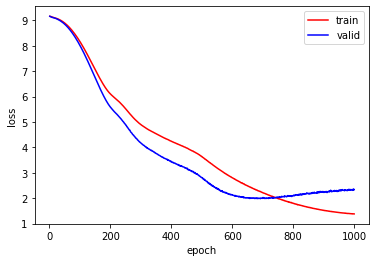

<Figure size 432x288 with 0 Axes>

In [39]:
x = np.arange(1, train_results.shape[0]+1)
plt.plot(x, train_results[:, 0], label='train', color='red')
plt.plot(x, valid_results[:, 0], label='valid', color='blue')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.savefig(opt.output_dir+'/loss.png')

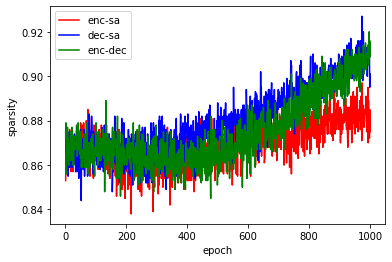

<Figure size 432x288 with 0 Axes>

In [40]:
plt.plot(x, sparsity_results[:, 0], label='enc-sa', color='red')
plt.plot(x, sparsity_results[:, 1], label='dec-sa', color='blue')
plt.plot(x, sparsity_results[:, 2], label='enc-dec', color='green')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('sparsity')
plt.show()
plt.savefig(opt.output_dir+'/sparsity.png')